In [1]:
import torch as torch
import pandas as pd
import numpy as np
import math
from sklearn import preprocessing
from neuralnetwork import *
from reading import *
from ADDA_Perso.ADDA import *
from ADDA_Perso.Training import *
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import umap

torch.cuda.set_device(1)
device = ("cuda:1" if torch.cuda.is_available() else"cpu")
print(f"Using {device} from {torch.cuda.get_device_name()}")

2023-07-20 10:11:35.444602: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-20 10:11:37.634419: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-07-20 10:11:37.634605: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-07-20 10:11:37.634616: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like t

Using cuda:1 from NVIDIA GeForce RTX 2080 Ti


/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help` for usage information.


/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help` for usage information.




In [2]:
dataCell = domain_selection(2)
print("_________________________")
dataPatient = domain_selection(3)
print("_________________________")
cellDataloaders, input_dim, _ = arrange_data_into_dataloaders(dataCell, base_bs = 32, device = device)
print("_________________________")
patientDataloaders, input_dim, datasetPatient = arrange_data_into_dataloaders(dataPatient,  base_bs = 32, device = device)
patientDataloadersExtractor, input_dim = use_dataset(datasetPatient,  base_bs = 32)
output_dim = 1
loss_function = torch.nn.BCELoss()
classifier_loss_function = torch.nn.BCELoss()
d_loss_function = torch.nn.BCELoss()

Selection Cell domain source
All done
Name of the variable containing all cell data : cell_data
6643
_________________________
Selection Patient domain source
All done
Name of the variable containing all the data : Patient_data
21244
_________________________
_________________________
21244 elements in the dataset
14870 elements in trainset
3187 elements in valset
3187 elements in testset


In [3]:
source_net = Extractor(input_dim).to(device)
classifier = Classifier().to(device)
target_net = Extractor(input_dim).to(device)
discri = Wass_Discriminator(128).to(device)

target_optimizer = torch.optim.Adam(target_net.parameters(), lr=1e-4)
d_optimizer = torch.optim.Adam(discri.parameters(), lr=1e-4)

exp_param_origin="Cell_to_Patient_500_batch32_lrDiscri1e-5_lrTarget1e-5_noBatchNormDiscri_variation_WassersteinTest_num3"
exp_param = exp_param_origin
name="logger/logger_adda_"+exp_param
logger = LogResWass(name)

In [4]:
%%time
for k in range(3):
    #cellDataloaders, input_dim = use_dataset(datasetCell, base_bs = 32)
    #cellDataloadersExtractor, input_dim = use_dataset(datasetCell, base_bs = 32)
    #patientDataloaders, input_dim = use_dataset(datasetPatient, base_bs = 32)
    if k==0:
        exp_param = exp_param+"_net_"+str(k)
    else:
        exp_param = exp_param.replace("_net_"+str(k-1),"_net_"+str(k))
    
    source_net = Extractor(input_dim).to(device)
    classifier = Classifier().to(device)
    target_net = Extractor(input_dim).to(device)
    discri = Wass_Discriminator(128).to(device)

    target_optimizer = torch.optim.Adam(target_net.parameters(), lr=1e-5)
    d_optimizer = torch.optim.Adam(discri.parameters(), lr=1e-5)

    train_source(
        100,
        source_net, 
        classifier, patientDataloaders, classifier_loss_function, device,log=False)

    target_net.load_state_dict(source_net.state_dict())
    data_historique, domain_historique, cancer_historique = train_target(
        500, 
        source_net, 
        classifier,
        target_net, 
        discri, 
        target_optimizer, 
        d_optimizer, 
        loss_function, 
        d_loss_function, 
        cellDataloaders, 
        patientDataloaders,
        patientDataloadersExtractor,
        exp_param,
        10,
        device,
        1000,
        1,
        logger,
        True,
        True,
        log=False
    )

100%|██████████| 100/100 [10:53<00:00,  6.53s/it]


0.7350892762491671
 PCA Domain Ground Truth
 PCA Cancer/Sain Ground Truth
Epoch number : 0
 UMAP Domain Ground Truth
 UMAP Cancer/Sain Ground Truth
0.7352160342402094
 PCA Domain Ground Truth
 PCA Cancer/Sain Ground Truth
Epoch number : 0
 UMAP Domain Ground Truth
 UMAP Cancer/Sain Ground Truth
0.7345644790448601
 PCA Domain Ground Truth
 PCA Cancer/Sain Ground Truth
Epoch number : 0
 UMAP Domain Ground Truth
 UMAP Cancer/Sain Ground Truth


  0%|          | 0/500 [00:00<?, ?it/s]

 Epoch nimber : 0 Discri total loss: 7.703854084014893, loss_target: -0.3761310577392578, loss_source: 0.32731226086616516, diff Target-Source 0.7034432888031006, gradient penalty value : 7.680293083190918 



  0%|          | 1/500 [00:03<26:20,  3.17s/it]

 Epoch nimber : 1 Discri total loss: 6.196544170379639, loss_target: -0.7968629598617554, loss_source: 0.5287120342254639, diff Target-Source 1.3255749940872192, gradient penalty value : 5.808349609375 



  0%|          | 2/500 [00:04<17:00,  2.05s/it]

 Epoch nimber : 2 Discri total loss: 4.852072715759277, loss_target: -1.0893540382385254, loss_source: 1.0114030838012695, diff Target-Source 2.100757122039795, gradient penalty value : 4.791742324829102 



  1%|          | 3/500 [00:05<13:48,  1.67s/it]

 Epoch nimber : 3 Discri total loss: 3.8896899223327637, loss_target: -1.3461129665374756, loss_source: 1.6005370616912842, diff Target-Source 2.9466500282287598, gradient penalty value : 3.881589889526367 



  1%|          | 4/500 [00:06<12:29,  1.51s/it]

 Epoch nimber : 4 Discri total loss: 3.4199841022491455, loss_target: -1.5452064275741577, loss_source: 1.4199497699737549, diff Target-Source 2.965156078338623, gradient penalty value : 3.667426586151123 



  1%|          | 5/500 [00:10<17:17,  2.10s/it]

 Epoch nimber : 5 Discri total loss: 2.9070708751678467, loss_target: -1.7537860870361328, loss_source: 1.8567776679992676, diff Target-Source 3.6105637550354004, gradient penalty value : 2.8906493186950684 



  1%|          | 6/500 [00:11<14:47,  1.80s/it]

 Epoch nimber : 6 Discri total loss: 2.7631938457489014, loss_target: -1.7730509042739868, loss_source: 1.9714608192443848, diff Target-Source 3.744511604309082, gradient penalty value : 3.119560480117798 



  1%|▏         | 7/500 [00:12<13:13,  1.61s/it]

 Epoch nimber : 7 Discri total loss: 4.614901065826416, loss_target: -2.008790969848633, loss_source: 1.5334473848342896, diff Target-Source 3.542238235473633, gradient penalty value : 4.376269340515137 



  2%|▏         | 8/500 [00:13<12:09,  1.48s/it]

 Epoch nimber : 8 Discri total loss: 3.681175708770752, loss_target: -2.1974942684173584, loss_source: 1.5144108533859253, diff Target-Source 3.711905002593994, gradient penalty value : 2.97816801071167 



  2%|▏         | 9/500 [00:16<15:35,  1.91s/it]

 Epoch nimber : 9 Discri total loss: 3.754256010055542, loss_target: -2.111976146697998, loss_source: 2.0481719970703125, diff Target-Source 4.1601481437683105, gradient penalty value : 2.993359327316284 



  2%|▏         | 10/500 [00:17<13:53,  1.70s/it]

 Epoch nimber : 10 Discri total loss: 3.6692380905151367, loss_target: -2.3882346153259277, loss_source: 1.732295274734497, diff Target-Source 4.120530128479004, gradient penalty value : 2.9342291355133057 



  2%|▏         | 11/500 [00:19<12:40,  1.56s/it]

 Epoch nimber : 11 Discri total loss: 2.3437793254852295, loss_target: -2.467829704284668, loss_source: 2.5329806804656982, diff Target-Source 5.000810623168945, gradient penalty value : 2.8438720703125 



  2%|▏         | 12/500 [00:20<11:51,  1.46s/it]

 Epoch nimber : 12 Discri total loss: 2.2704241275787354, loss_target: -2.496091365814209, loss_source: 2.6662895679473877, diff Target-Source 5.162381172180176, gradient penalty value : 2.237541675567627 



  3%|▎         | 13/500 [00:23<15:17,  1.88s/it]

 Epoch nimber : 13 Discri total loss: 3.2338569164276123, loss_target: -2.5973100662231445, loss_source: 2.6051993370056152, diff Target-Source 5.20250940322876, gradient penalty value : 2.8944692611694336 



  3%|▎         | 14/500 [00:24<13:40,  1.69s/it]

 Epoch nimber : 14 Discri total loss: 2.5789947509765625, loss_target: -2.7223188877105713, loss_source: 2.571077823638916, diff Target-Source 5.293396949768066, gradient penalty value : 2.2797164916992188 



  3%|▎         | 15/500 [00:25<12:32,  1.55s/it]

 Epoch nimber : 15 Discri total loss: 2.8287737369537354, loss_target: -2.8500595092773438, loss_source: 2.344730854034424, diff Target-Source 5.194790363311768, gradient penalty value : 2.766512632369995 



  3%|▎         | 16/500 [00:26<11:48,  1.46s/it]

 Epoch nimber : 16 Discri total loss: 3.0008468627929688, loss_target: -3.02272367477417, loss_source: 2.4133377075195312, diff Target-Source 5.436061382293701, gradient penalty value : 1.7699283361434937 



  3%|▎         | 17/500 [00:29<15:20,  1.91s/it]

 Epoch nimber : 17 Discri total loss: 2.9693593978881836, loss_target: -2.822650909423828, loss_source: 2.271651268005371, diff Target-Source 5.094302177429199, gradient penalty value : 2.6255335807800293 



  4%|▎         | 18/500 [00:31<13:44,  1.71s/it]

 Epoch nimber : 18 Discri total loss: 1.9807500839233398, loss_target: -2.9537389278411865, loss_source: 3.0739734172821045, diff Target-Source 6.027712345123291, gradient penalty value : 2.5362417697906494 



  4%|▍         | 19/500 [00:32<12:35,  1.57s/it]

 Epoch nimber : 19 Discri total loss: 2.532346487045288, loss_target: -3.1030826568603516, loss_source: 2.8042304515838623, diff Target-Source 5.907313346862793, gradient penalty value : 2.308516025543213 



  4%|▍         | 20/500 [00:33<11:43,  1.47s/it]

 Epoch nimber : 20 Discri total loss: 2.602900981903076, loss_target: -3.09918212890625, loss_source: 2.5500950813293457, diff Target-Source 5.649277210235596, gradient penalty value : 1.8003302812576294 



  4%|▍         | 21/500 [00:36<15:44,  1.97s/it]

 Epoch nimber : 21 Discri total loss: 2.1853482723236084, loss_target: -3.1647486686706543, loss_source: 2.6492362022399902, diff Target-Source 5.8139848709106445, gradient penalty value : 2.122880697250366 



  4%|▍         | 22/500 [00:37<13:55,  1.75s/it]

 Epoch nimber : 22 Discri total loss: 2.993508815765381, loss_target: -3.2834270000457764, loss_source: 2.4423394203186035, diff Target-Source 5.725766181945801, gradient penalty value : 2.5389957427978516 



  5%|▍         | 23/500 [00:39<12:41,  1.60s/it]

 Epoch nimber : 23 Discri total loss: 1.8754055500030518, loss_target: -3.2540197372436523, loss_source: 4.057143211364746, diff Target-Source 7.311162948608398, gradient penalty value : 2.618619203567505 



  5%|▍         | 24/500 [00:40<11:51,  1.49s/it]

 Epoch nimber : 24 Discri total loss: 3.2075769901275635, loss_target: -3.3322622776031494, loss_source: 2.621382713317871, diff Target-Source 5.953644752502441, gradient penalty value : 2.2667689323425293 



  5%|▌         | 25/500 [00:43<15:29,  1.96s/it]

 Epoch nimber : 25 Discri total loss: 0.9635982513427734, loss_target: -3.361013412475586, loss_source: 3.179780960083008, diff Target-Source 6.540794372558594, gradient penalty value : 1.277266502380371 



  5%|▌         | 26/500 [00:44<13:45,  1.74s/it]

 Epoch nimber : 26 Discri total loss: 2.405582904815674, loss_target: -3.3064637184143066, loss_source: 2.87534499168396, diff Target-Source 6.1818084716796875, gradient penalty value : 1.6432183980941772 



  5%|▌         | 27/500 [00:45<12:29,  1.59s/it]

 Epoch nimber : 27 Discri total loss: 3.3291640281677246, loss_target: -3.367129325866699, loss_source: 2.8542003631591797, diff Target-Source 6.221329689025879, gradient penalty value : 2.924872875213623 



  6%|▌         | 28/500 [00:47<11:42,  1.49s/it]

 Epoch nimber : 28 Discri total loss: 1.7814421653747559, loss_target: -3.3794639110565186, loss_source: 3.096053123474121, diff Target-Source 6.475517272949219, gradient penalty value : 2.3541178703308105 



  6%|▌         | 29/500 [00:49<14:56,  1.90s/it]

 Epoch nimber : 29 Discri total loss: 3.2162461280822754, loss_target: -3.42549729347229, loss_source: 2.3341927528381348, diff Target-Source 5.759690284729004, gradient penalty value : 1.8889178037643433 



  6%|▌         | 30/500 [00:51<13:18,  1.70s/it]

 Epoch nimber : 30 Discri total loss: 2.6141443252563477, loss_target: -3.472728729248047, loss_source: 2.8046984672546387, diff Target-Source 6.2774271965026855, gradient penalty value : 2.154233455657959 



  6%|▌         | 31/500 [00:52<12:15,  1.57s/it]

 Epoch nimber : 31 Discri total loss: 2.844717025756836, loss_target: -3.5307230949401855, loss_source: 2.31196928024292, diff Target-Source 5.8426923751831055, gradient penalty value : 1.8154017925262451 



  6%|▋         | 32/500 [00:53<11:25,  1.47s/it]

 Epoch nimber : 32 Discri total loss: 2.216733455657959, loss_target: -3.6361098289489746, loss_source: 3.0821731090545654, diff Target-Source 6.718282699584961, gradient penalty value : 1.8708574771881104 



  7%|▋         | 33/500 [00:56<15:00,  1.93s/it]

 Epoch nimber : 33 Discri total loss: 1.536594033241272, loss_target: -3.5105555057525635, loss_source: 3.4098684787750244, diff Target-Source 6.920423984527588, gradient penalty value : 1.5180505514144897 



  7%|▋         | 34/500 [00:57<13:20,  1.72s/it]

 Epoch nimber : 34 Discri total loss: 3.004767417907715, loss_target: -3.6029748916625977, loss_source: 2.6683592796325684, diff Target-Source 6.271334171295166, gradient penalty value : 2.3710830211639404 



  7%|▋         | 35/500 [00:59<12:12,  1.58s/it]

 Epoch nimber : 35 Discri total loss: 2.858110189437866, loss_target: -3.5591344833374023, loss_source: 2.65605092048645, diff Target-Source 6.215185165405273, gradient penalty value : 2.036186695098877 



  7%|▋         | 36/500 [01:00<11:22,  1.47s/it]

 Epoch nimber : 36 Discri total loss: 2.219583511352539, loss_target: -3.551476001739502, loss_source: 3.0642659664154053, diff Target-Source 6.615741729736328, gradient penalty value : 1.847285270690918 



  7%|▋         | 37/500 [01:03<14:55,  1.93s/it]

 Epoch nimber : 37 Discri total loss: 1.2148752212524414, loss_target: -3.6976776123046875, loss_source: 3.7713353633880615, diff Target-Source 7.469013214111328, gradient penalty value : 1.7514076232910156 



  8%|▊         | 38/500 [01:04<13:17,  1.73s/it]

 Epoch nimber : 38 Discri total loss: 3.959402561187744, loss_target: -3.7670295238494873, loss_source: 2.3065686225891113, diff Target-Source 6.0735979080200195, gradient penalty value : 2.8086800575256348 



  8%|▊         | 39/500 [01:05<12:06,  1.58s/it]

 Epoch nimber : 39 Discri total loss: 2.2855381965637207, loss_target: -3.579030990600586, loss_source: 3.1228463649749756, diff Target-Source 6.701877593994141, gradient penalty value : 1.837540626525879 



  8%|▊         | 40/500 [01:07<11:20,  1.48s/it]

 Epoch nimber : 40 Discri total loss: 3.2941296100616455, loss_target: -3.7024011611938477, loss_source: 2.611814022064209, diff Target-Source 6.314215183258057, gradient penalty value : 2.4527833461761475 



  8%|▊         | 41/500 [01:10<14:45,  1.93s/it]

 Epoch nimber : 41 Discri total loss: 3.596184492111206, loss_target: -3.8087100982666016, loss_source: 2.6573894023895264, diff Target-Source 6.466099739074707, gradient penalty value : 2.382369041442871 



  8%|▊         | 42/500 [01:11<13:08,  1.72s/it]

 Epoch nimber : 42 Discri total loss: 3.1206705570220947, loss_target: -3.896815776824951, loss_source: 2.833242893218994, diff Target-Source 6.730058670043945, gradient penalty value : 1.8639423847198486 



  9%|▊         | 43/500 [01:12<12:04,  1.58s/it]

 Epoch nimber : 43 Discri total loss: 2.791414737701416, loss_target: -3.846529483795166, loss_source: 2.889934539794922, diff Target-Source 6.736464023590088, gradient penalty value : 2.234379291534424 



  9%|▉         | 44/500 [01:13<11:16,  1.48s/it]

 Epoch nimber : 44 Discri total loss: 1.4911028146743774, loss_target: -3.8166146278381348, loss_source: 3.7972211837768555, diff Target-Source 7.61383581161499, gradient penalty value : 1.4345425367355347 



  9%|▉         | 45/500 [01:16<14:29,  1.91s/it]

 Epoch nimber : 45 Discri total loss: 2.3584275245666504, loss_target: -3.917515754699707, loss_source: 3.148641586303711, diff Target-Source 7.066157341003418, gradient penalty value : 1.796468734741211 



  9%|▉         | 46/500 [01:17<12:52,  1.70s/it]

 Epoch nimber : 46 Discri total loss: 2.7814552783966064, loss_target: -3.91562557220459, loss_source: 2.640817165374756, diff Target-Source 6.556442737579346, gradient penalty value : 1.906332015991211 



  9%|▉         | 47/500 [01:19<11:48,  1.56s/it]

 Epoch nimber : 47 Discri total loss: 2.535792827606201, loss_target: -3.983638048171997, loss_source: 3.37764835357666, diff Target-Source 7.361286163330078, gradient penalty value : 1.8798929452896118 



 10%|▉         | 48/500 [01:20<11:05,  1.47s/it]

 Epoch nimber : 48 Discri total loss: 2.020315170288086, loss_target: -3.9547629356384277, loss_source: 3.6495189666748047, diff Target-Source 7.604281902313232, gradient penalty value : 1.8810334205627441 



 10%|▉         | 49/500 [01:23<14:12,  1.89s/it]

 Epoch nimber : 49 Discri total loss: 1.7793185710906982, loss_target: -4.0452070236206055, loss_source: 3.546085834503174, diff Target-Source 7.591292858123779, gradient penalty value : 1.315124273300171 



 10%|█         | 50/500 [01:24<12:45,  1.70s/it]

 Epoch nimber : 50 Discri total loss: 2.92732310295105, loss_target: -4.020623207092285, loss_source: 3.0600500106811523, diff Target-Source 7.0806732177734375, gradient penalty value : 1.9913442134857178 



 10%|█         | 51/500 [01:25<11:43,  1.57s/it]

 Epoch nimber : 51 Discri total loss: 2.5320615768432617, loss_target: -4.134282112121582, loss_source: 3.0686049461364746, diff Target-Source 7.202887058258057, gradient penalty value : 1.529954433441162 



 10%|█         | 52/500 [01:28<14:47,  1.98s/it]

 Epoch nimber : 52 Discri total loss: 1.4375331401824951, loss_target: -3.856147527694702, loss_source: 3.8136563301086426, diff Target-Source 7.669803619384766, gradient penalty value : 1.4033267498016357 



 11%|█         | 53/500 [01:30<13:05,  1.76s/it]

 Epoch nimber : 53 Discri total loss: 2.177517890930176, loss_target: -3.9210219383239746, loss_source: 3.215235710144043, diff Target-Source 7.136257648468018, gradient penalty value : 1.7417492866516113 



 11%|█         | 54/500 [01:31<11:54,  1.60s/it]

 Epoch nimber : 54 Discri total loss: 3.173905372619629, loss_target: -3.9372763633728027, loss_source: 2.6015939712524414, diff Target-Source 6.538870334625244, gradient penalty value : 1.6194230318069458 



 11%|█         | 55/500 [01:32<11:03,  1.49s/it]

 Epoch nimber : 55 Discri total loss: 2.0700314044952393, loss_target: -4.129831314086914, loss_source: 3.328826427459717, diff Target-Source 7.458657741546631, gradient penalty value : 1.5585761070251465 



 11%|█         | 56/500 [01:35<14:31,  1.96s/it]

 Epoch nimber : 56 Discri total loss: 1.939965009689331, loss_target: -4.130388259887695, loss_source: 3.5295543670654297, diff Target-Source 7.659942626953125, gradient penalty value : 1.212406873703003 



 11%|█▏        | 57/500 [01:36<12:52,  1.74s/it]

 Epoch nimber : 57 Discri total loss: 2.459747791290283, loss_target: -4.052581310272217, loss_source: 3.705475330352783, diff Target-Source 7.758056640625, gradient penalty value : 2.05300235748291 



 12%|█▏        | 58/500 [01:38<11:43,  1.59s/it]

 Epoch nimber : 58 Discri total loss: 3.2237539291381836, loss_target: -4.289483070373535, loss_source: 3.005136251449585, diff Target-Source 7.294619560241699, gradient penalty value : 2.5115509033203125 



 12%|█▏        | 59/500 [01:39<10:57,  1.49s/it]

 Epoch nimber : 59 Discri total loss: 2.705807685852051, loss_target: -3.968608856201172, loss_source: 3.275841236114502, diff Target-Source 7.244450092315674, gradient penalty value : 2.0853078365325928 



 12%|█▏        | 60/500 [01:42<14:11,  1.94s/it]

 Epoch nimber : 60 Discri total loss: 2.808046579360962, loss_target: -4.129091739654541, loss_source: 3.7438762187957764, diff Target-Source 7.872967720031738, gradient penalty value : 1.7776765823364258 



 12%|█▏        | 61/500 [01:43<12:34,  1.72s/it]

 Epoch nimber : 61 Discri total loss: 4.510166168212891, loss_target: -4.27513313293457, loss_source: 2.669962167739868, diff Target-Source 6.945095062255859, gradient penalty value : 2.7812981605529785 



 12%|█▏        | 62/500 [01:44<11:28,  1.57s/it]

 Epoch nimber : 62 Discri total loss: 2.13175630569458, loss_target: -4.271836280822754, loss_source: 3.7018697261810303, diff Target-Source 7.973706245422363, gradient penalty value : 1.7612278461456299 



 13%|█▎        | 63/500 [01:45<10:41,  1.47s/it]

 Epoch nimber : 63 Discri total loss: 2.8989675045013428, loss_target: -4.3307905197143555, loss_source: 3.1419429779052734, diff Target-Source 7.472733497619629, gradient penalty value : 2.210693120956421 



 13%|█▎        | 64/500 [01:48<13:48,  1.90s/it]

 Epoch nimber : 64 Discri total loss: 2.835526943206787, loss_target: -3.9701437950134277, loss_source: 2.864420175552368, diff Target-Source 6.834564208984375, gradient penalty value : 1.7665038108825684 



 13%|█▎        | 65/500 [01:50<12:21,  1.70s/it]

 Epoch nimber : 65 Discri total loss: 1.4554851055145264, loss_target: -4.333830833435059, loss_source: 3.842345952987671, diff Target-Source 8.176177024841309, gradient penalty value : 1.4069085121154785 



 13%|█▎        | 66/500 [01:51<11:19,  1.57s/it]

 Epoch nimber : 66 Discri total loss: 3.032437801361084, loss_target: -4.209260940551758, loss_source: 3.1851038932800293, diff Target-Source 7.394364833831787, gradient penalty value : 2.001837730407715 



 13%|█▎        | 67/500 [01:52<10:42,  1.48s/it]

 Epoch nimber : 67 Discri total loss: 2.4746689796447754, loss_target: -4.188615322113037, loss_source: 4.136833190917969, diff Target-Source 8.325448989868164, gradient penalty value : 1.5919766426086426 



 14%|█▎        | 68/500 [01:55<13:48,  1.92s/it]

 Epoch nimber : 68 Discri total loss: 2.6070008277893066, loss_target: -4.326085090637207, loss_source: 3.6055688858032227, diff Target-Source 7.93165397644043, gradient penalty value : 1.6154729127883911 



 14%|█▍        | 69/500 [01:56<12:21,  1.72s/it]

 Epoch nimber : 69 Discri total loss: 2.1670260429382324, loss_target: -4.339739799499512, loss_source: 3.5525729656219482, diff Target-Source 7.892313003540039, gradient penalty value : 1.4842865467071533 



 14%|█▍        | 70/500 [01:58<11:16,  1.57s/it]

 Epoch nimber : 70 Discri total loss: 3.1282615661621094, loss_target: -4.41472864151001, loss_source: 2.992196559906006, diff Target-Source 7.406925201416016, gradient penalty value : 1.8872771263122559 



 14%|█▍        | 71/500 [01:59<10:31,  1.47s/it]

 Epoch nimber : 71 Discri total loss: 3.0334157943725586, loss_target: -4.431617736816406, loss_source: 3.1741371154785156, diff Target-Source 7.605754852294922, gradient penalty value : 2.125481128692627 



 14%|█▍        | 72/500 [02:02<13:52,  1.95s/it]

 Epoch nimber : 72 Discri total loss: 3.1162214279174805, loss_target: -4.342308044433594, loss_source: 3.599125385284424, diff Target-Source 7.941433429718018, gradient penalty value : 2.5204110145568848 



 15%|█▍        | 73/500 [02:03<12:22,  1.74s/it]

 Epoch nimber : 73 Discri total loss: 3.620441436767578, loss_target: -4.441150665283203, loss_source: 2.7678189277648926, diff Target-Source 7.208969593048096, gradient penalty value : 2.3141679763793945 



 15%|█▍        | 74/500 [02:04<11:18,  1.59s/it]

 Epoch nimber : 74 Discri total loss: 2.3444643020629883, loss_target: -4.471494674682617, loss_source: 3.3374228477478027, diff Target-Source 7.80891752243042, gradient penalty value : 1.4623942375183105 



 15%|█▌        | 75/500 [02:06<10:34,  1.49s/it]

 Epoch nimber : 75 Discri total loss: 2.9700891971588135, loss_target: -4.3175129890441895, loss_source: 3.407763957977295, diff Target-Source 7.725276947021484, gradient penalty value : 2.0006635189056396 



 15%|█▌        | 76/500 [02:08<13:28,  1.91s/it]

 Epoch nimber : 76 Discri total loss: 2.618227481842041, loss_target: -4.44044303894043, loss_source: 3.2722415924072266, diff Target-Source 7.712684631347656, gradient penalty value : 1.5753780603408813 



 15%|█▌        | 77/500 [02:10<11:59,  1.70s/it]

 Epoch nimber : 77 Discri total loss: 2.532500743865967, loss_target: -4.250466346740723, loss_source: 3.3611717224121094, diff Target-Source 7.611638069152832, gradient penalty value : 1.52812659740448 



 16%|█▌        | 78/500 [02:11<10:56,  1.56s/it]

 Epoch nimber : 78 Discri total loss: 3.2859179973602295, loss_target: -4.392224311828613, loss_source: 3.3519623279571533, diff Target-Source 7.7441864013671875, gradient penalty value : 2.342167854309082 



 16%|█▌        | 79/500 [02:12<10:17,  1.47s/it]

 Epoch nimber : 79 Discri total loss: 2.1962227821350098, loss_target: -4.288590431213379, loss_source: 3.4718260765075684, diff Target-Source 7.760416507720947, gradient penalty value : 1.6498565673828125 



 16%|█▌        | 80/500 [02:15<13:13,  1.89s/it]

 Epoch nimber : 80 Discri total loss: 2.6602795124053955, loss_target: -4.474383354187012, loss_source: 3.006254196166992, diff Target-Source 7.480637550354004, gradient penalty value : 1.3443100452423096 



 16%|█▌        | 81/500 [02:16<11:54,  1.70s/it]

 Epoch nimber : 81 Discri total loss: 2.9022340774536133, loss_target: -4.428930282592773, loss_source: 3.00195050239563, diff Target-Source 7.430880546569824, gradient penalty value : 1.6677159070968628 



 16%|█▋        | 82/500 [02:18<10:52,  1.56s/it]

 Epoch nimber : 82 Discri total loss: 2.734513759613037, loss_target: -4.462447166442871, loss_source: 3.3239903450012207, diff Target-Source 7.786437511444092, gradient penalty value : 1.490267276763916 



 17%|█▋        | 83/500 [02:19<10:11,  1.47s/it]

 Epoch nimber : 83 Discri total loss: 2.2217602729797363, loss_target: -4.38862419128418, loss_source: 3.4030826091766357, diff Target-Source 7.7917070388793945, gradient penalty value : 1.387433409690857 



 17%|█▋        | 84/500 [02:22<13:16,  1.91s/it]

 Epoch nimber : 84 Discri total loss: 1.3783228397369385, loss_target: -4.4523468017578125, loss_source: 4.207381248474121, diff Target-Source 8.659728050231934, gradient penalty value : 1.5411369800567627 



 17%|█▋        | 85/500 [02:23<11:52,  1.72s/it]

 Epoch nimber : 85 Discri total loss: 2.996272563934326, loss_target: -4.413733959197998, loss_source: 3.7134432792663574, diff Target-Source 8.127177238464355, gradient penalty value : 1.701979637145996 



 17%|█▋        | 86/500 [02:24<10:55,  1.58s/it]

 Epoch nimber : 86 Discri total loss: 2.889033555984497, loss_target: -4.415184497833252, loss_source: 3.031352996826172, diff Target-Source 7.446537494659424, gradient penalty value : 1.793842077255249 



 17%|█▋        | 87/500 [02:26<10:13,  1.48s/it]

 Epoch nimber : 87 Discri total loss: 2.2722249031066895, loss_target: -4.2997260093688965, loss_source: 3.4433860778808594, diff Target-Source 7.743112087249756, gradient penalty value : 1.926588773727417 



 18%|█▊        | 88/500 [02:28<12:49,  1.87s/it]

 Epoch nimber : 88 Discri total loss: 2.369048595428467, loss_target: -4.417537689208984, loss_source: 3.4808244705200195, diff Target-Source 7.898362159729004, gradient penalty value : 1.553972840309143 



 18%|█▊        | 89/500 [02:30<11:31,  1.68s/it]

 Epoch nimber : 89 Discri total loss: 2.1711974143981934, loss_target: -4.3770670890808105, loss_source: 3.9975152015686035, diff Target-Source 8.374582290649414, gradient penalty value : 1.834833025932312 



 18%|█▊        | 90/500 [02:31<10:38,  1.56s/it]

 Epoch nimber : 90 Discri total loss: 3.075646162033081, loss_target: -4.539780139923096, loss_source: 3.4094109535217285, diff Target-Source 7.949191093444824, gradient penalty value : 1.878666639328003 



 18%|█▊        | 91/500 [02:32<10:02,  1.47s/it]

 Epoch nimber : 91 Discri total loss: 1.4729511737823486, loss_target: -4.497607707977295, loss_source: 4.394347190856934, diff Target-Source 8.89195442199707, gradient penalty value : 1.517183542251587 



 18%|█▊        | 92/500 [02:35<13:22,  1.97s/it]

 Epoch nimber : 92 Discri total loss: 2.931414842605591, loss_target: -4.456888198852539, loss_source: 3.0758869647979736, diff Target-Source 7.532774925231934, gradient penalty value : 1.4695115089416504 



 19%|█▊        | 93/500 [02:36<11:52,  1.75s/it]

 Epoch nimber : 93 Discri total loss: 0.9537056684494019, loss_target: -4.532845497131348, loss_source: 4.428564548492432, diff Target-Source 8.961410522460938, gradient penalty value : 1.0274289846420288 



 19%|█▉        | 94/500 [02:38<10:43,  1.59s/it]

 Epoch nimber : 94 Discri total loss: 2.3472676277160645, loss_target: -4.442826747894287, loss_source: 3.268921375274658, diff Target-Source 7.711748123168945, gradient penalty value : 1.7143744230270386 



 19%|█▉        | 95/500 [02:41<13:33,  2.01s/it]

 Epoch nimber : 95 Discri total loss: 2.611377716064453, loss_target: -4.376112937927246, loss_source: 3.2930498123168945, diff Target-Source 7.669162750244141, gradient penalty value : 1.4288382530212402 



 19%|█▉        | 96/500 [02:42<11:58,  1.78s/it]

 Epoch nimber : 96 Discri total loss: 0.7806378602981567, loss_target: -4.519608020782471, loss_source: 4.604320526123047, diff Target-Source 9.12392807006836, gradient penalty value : 1.4526420831680298 



 19%|█▉        | 97/500 [02:43<10:52,  1.62s/it]

 Epoch nimber : 97 Discri total loss: 2.086873769760132, loss_target: -4.537480354309082, loss_source: 4.131346702575684, diff Target-Source 8.668827056884766, gradient penalty value : 1.7054660320281982 



 20%|█▉        | 98/500 [02:44<10:04,  1.50s/it]

 Epoch nimber : 98 Discri total loss: 2.257847309112549, loss_target: -4.419415473937988, loss_source: 3.8271589279174805, diff Target-Source 8.246574401855469, gradient penalty value : 1.6101528406143188 



 20%|█▉        | 99/500 [02:47<12:25,  1.86s/it]

 Epoch nimber : 99 Discri total loss: 1.3460445404052734, loss_target: -4.55349063873291, loss_source: 4.663823127746582, diff Target-Source 9.217313766479492, gradient penalty value : 1.608053207397461 



 20%|██        | 100/500 [02:48<11:10,  1.68s/it]

 Epoch nimber : 100 Discri total loss: 1.6567634344100952, loss_target: -4.5986833572387695, loss_source: 3.896289348602295, diff Target-Source 8.494972229003906, gradient penalty value : 1.2584799528121948 

0.6043533705482015
 PCA Domain Ground Truth
 PCA Cancer/Sain Ground Truth
Epoch number : 100
 UMAP Domain Ground Truth
 UMAP Cancer/Sain Ground Truth
0.5977168660727141
 PCA Domain Ground Truth
 PCA Cancer/Sain Ground Truth
Epoch number : 100
 UMAP Domain Ground Truth
 UMAP Cancer/Sain Ground Truth
0.6001652772672394
 PCA Domain Ground Truth
 PCA Cancer/Sain Ground Truth
Epoch number : 100
 UMAP Domain Ground Truth
 UMAP Cancer/Sain Ground Truth


 20%|██        | 101/500 [03:24<1:19:54, 12.02s/it]

 Epoch nimber : 101 Discri total loss: 1.4993104934692383, loss_target: -4.516720294952393, loss_source: 4.584718227386475, diff Target-Source 9.101438522338867, gradient penalty value : 1.6183204650878906 



 20%|██        | 102/500 [03:28<1:02:55,  9.49s/it]

 Epoch nimber : 102 Discri total loss: 2.901819944381714, loss_target: -4.49349308013916, loss_source: 3.6580066680908203, diff Target-Source 8.15149974822998, gradient penalty value : 1.7796170711517334 



 21%|██        | 103/500 [03:29<46:25,  7.02s/it]  

 Epoch nimber : 103 Discri total loss: 3.3889052867889404, loss_target: -4.489782333374023, loss_source: 3.674794912338257, diff Target-Source 8.16457748413086, gradient penalty value : 2.278533935546875 



 21%|██        | 104/500 [03:31<34:55,  5.29s/it]

 Epoch nimber : 104 Discri total loss: 2.2542853355407715, loss_target: -4.516061782836914, loss_source: 3.5871453285217285, diff Target-Source 8.103206634521484, gradient penalty value : 1.3670835494995117 



 21%|██        | 105/500 [03:32<26:52,  4.08s/it]

 Epoch nimber : 105 Discri total loss: 2.3218698501586914, loss_target: -4.485330581665039, loss_source: 3.525857925415039, diff Target-Source 8.011188507080078, gradient penalty value : 1.4001717567443848 



 21%|██        | 106/500 [03:35<24:49,  3.78s/it]

 Epoch nimber : 106 Discri total loss: 2.3072571754455566, loss_target: -4.579037666320801, loss_source: 3.503481388092041, diff Target-Source 8.08251953125, gradient penalty value : 1.3866108655929565 



 21%|██▏       | 107/500 [03:36<19:48,  3.03s/it]

 Epoch nimber : 107 Discri total loss: 2.0360283851623535, loss_target: -4.636711120605469, loss_source: 4.0322065353393555, diff Target-Source 8.668917655944824, gradient penalty value : 1.777199625968933 



 22%|██▏       | 108/500 [03:37<16:18,  2.50s/it]

 Epoch nimber : 108 Discri total loss: 0.7029851675033569, loss_target: -4.614556789398193, loss_source: 5.124892234802246, diff Target-Source 9.739448547363281, gradient penalty value : 1.049289584159851 



 22%|██▏       | 109/500 [03:39<13:52,  2.13s/it]

 Epoch nimber : 109 Discri total loss: 1.8375654220581055, loss_target: -4.679173946380615, loss_source: 4.1872453689575195, diff Target-Source 8.866418838500977, gradient penalty value : 1.4944171905517578 



 22%|██▏       | 110/500 [03:42<15:40,  2.41s/it]

 Epoch nimber : 110 Discri total loss: 1.6279478073120117, loss_target: -4.523646831512451, loss_source: 4.010362148284912, diff Target-Source 8.534008979797363, gradient penalty value : 1.6761789321899414 



 22%|██▏       | 111/500 [03:43<13:21,  2.06s/it]

 Epoch nimber : 111 Discri total loss: 2.1819589138031006, loss_target: -4.679571151733398, loss_source: 3.460583209991455, diff Target-Source 8.140153884887695, gradient penalty value : 1.1735174655914307 



 22%|██▏       | 112/500 [03:44<11:49,  1.83s/it]

 Epoch nimber : 112 Discri total loss: 2.3325753211975098, loss_target: -4.488852024078369, loss_source: 3.470489025115967, diff Target-Source 7.959341049194336, gradient penalty value : 1.4994031190872192 



 23%|██▎       | 113/500 [03:46<10:42,  1.66s/it]

 Epoch nimber : 113 Discri total loss: 2.5142602920532227, loss_target: -4.638734817504883, loss_source: 3.5209906101226807, diff Target-Source 8.159725189208984, gradient penalty value : 1.632336974143982 



 23%|██▎       | 114/500 [03:49<13:31,  2.10s/it]

 Epoch nimber : 114 Discri total loss: 3.348006010055542, loss_target: -4.520096302032471, loss_source: 3.468209743499756, diff Target-Source 7.988306045532227, gradient penalty value : 2.224200487136841 



 23%|██▎       | 115/500 [03:50<11:55,  1.86s/it]

 Epoch nimber : 115 Discri total loss: 2.183621883392334, loss_target: -4.626651763916016, loss_source: 3.730168581008911, diff Target-Source 8.356820106506348, gradient penalty value : 1.3749796152114868 



 23%|██▎       | 116/500 [03:51<10:45,  1.68s/it]

 Epoch nimber : 116 Discri total loss: 2.5329060554504395, loss_target: -4.615190505981445, loss_source: 3.4358487129211426, diff Target-Source 8.05103874206543, gradient penalty value : 1.5678614377975464 



 23%|██▎       | 117/500 [03:53<09:59,  1.56s/it]

 Epoch nimber : 117 Discri total loss: 3.454042434692383, loss_target: -4.690666675567627, loss_source: 3.4989285469055176, diff Target-Source 8.189595222473145, gradient penalty value : 1.883028507232666 



 24%|██▎       | 118/500 [03:56<13:08,  2.06s/it]

 Epoch nimber : 118 Discri total loss: 2.4452226161956787, loss_target: -4.580380439758301, loss_source: 3.715864658355713, diff Target-Source 8.296245574951172, gradient penalty value : 1.5849592685699463 



 24%|██▍       | 119/500 [03:57<11:39,  1.84s/it]

 Epoch nimber : 119 Discri total loss: 1.7858232259750366, loss_target: -4.522150993347168, loss_source: 4.230801105499268, diff Target-Source 8.752952575683594, gradient penalty value : 1.488782286643982 



 24%|██▍       | 120/500 [03:58<10:30,  1.66s/it]

 Epoch nimber : 120 Discri total loss: 2.2264795303344727, loss_target: -4.699287414550781, loss_source: 3.569394588470459, diff Target-Source 8.268682479858398, gradient penalty value : 1.5573678016662598 



 24%|██▍       | 121/500 [04:00<09:42,  1.54s/it]

 Epoch nimber : 121 Discri total loss: 1.7102155685424805, loss_target: -4.5146484375, loss_source: 3.774341106414795, diff Target-Source 8.288990020751953, gradient penalty value : 0.83633953332901 



 24%|██▍       | 122/500 [04:03<12:42,  2.02s/it]

 Epoch nimber : 122 Discri total loss: 2.4243907928466797, loss_target: -4.650424003601074, loss_source: 3.4775123596191406, diff Target-Source 8.127936363220215, gradient penalty value : 1.6513985395431519 



 25%|██▍       | 123/500 [04:04<11:16,  1.79s/it]

 Epoch nimber : 123 Discri total loss: 0.582650363445282, loss_target: -4.765418529510498, loss_source: 4.4705705642700195, diff Target-Source 9.23598861694336, gradient penalty value : 0.9256970286369324 



 25%|██▍       | 124/500 [04:05<10:12,  1.63s/it]

 Epoch nimber : 124 Discri total loss: 2.4167251586914062, loss_target: -4.73521089553833, loss_source: 3.654512405395508, diff Target-Source 8.38972282409668, gradient penalty value : 1.8883250951766968 



 25%|██▌       | 125/500 [04:07<09:29,  1.52s/it]

 Epoch nimber : 125 Discri total loss: 2.3117246627807617, loss_target: -4.617663383483887, loss_source: 3.7864599227905273, diff Target-Source 8.404123306274414, gradient penalty value : 1.6308259963989258 



 25%|██▌       | 126/500 [04:09<12:12,  1.96s/it]

 Epoch nimber : 126 Discri total loss: 3.166604995727539, loss_target: -4.732828617095947, loss_source: 3.2936573028564453, diff Target-Source 8.026485443115234, gradient penalty value : 1.9660940170288086 



 25%|██▌       | 127/500 [04:11<10:52,  1.75s/it]

 Epoch nimber : 127 Discri total loss: 2.9931888580322266, loss_target: -4.818206787109375, loss_source: 3.515981674194336, diff Target-Source 8.334188461303711, gradient penalty value : 1.3451074361801147 



 26%|██▌       | 128/500 [04:12<09:55,  1.60s/it]

 Epoch nimber : 128 Discri total loss: 2.129507064819336, loss_target: -4.684389114379883, loss_source: 3.7052061557769775, diff Target-Source 8.389595031738281, gradient penalty value : 1.143245816230774 



 26%|██▌       | 129/500 [04:13<09:17,  1.50s/it]

 Epoch nimber : 129 Discri total loss: 2.9414446353912354, loss_target: -4.699090957641602, loss_source: 3.4701902866363525, diff Target-Source 8.169281005859375, gradient penalty value : 1.5432167053222656 



 26%|██▌       | 130/500 [04:15<08:49,  1.43s/it]

 Epoch nimber : 130 Discri total loss: 2.387387275695801, loss_target: -4.733209609985352, loss_source: 4.120540142059326, diff Target-Source 8.853750228881836, gradient penalty value : 1.8064007759094238 



 26%|██▌       | 131/500 [04:18<11:42,  1.90s/it]

 Epoch nimber : 131 Discri total loss: 2.091052770614624, loss_target: -4.782664775848389, loss_source: 3.861575126647949, diff Target-Source 8.64423942565918, gradient penalty value : 1.2759425640106201 



 26%|██▋       | 132/500 [04:19<10:29,  1.71s/it]

 Epoch nimber : 132 Discri total loss: 3.2686917781829834, loss_target: -4.727029800415039, loss_source: 3.3699305057525635, diff Target-Source 8.096960067749023, gradient penalty value : 1.7254881858825684 



 27%|██▋       | 133/500 [04:20<09:39,  1.58s/it]

 Epoch nimber : 133 Discri total loss: 2.7067527770996094, loss_target: -4.654210567474365, loss_source: 3.734096050262451, diff Target-Source 8.388306617736816, gradient penalty value : 1.8561043739318848 



 27%|██▋       | 134/500 [04:21<08:59,  1.48s/it]

 Epoch nimber : 134 Discri total loss: 1.456366777420044, loss_target: -4.747383117675781, loss_source: 4.325334072113037, diff Target-Source 9.072717666625977, gradient penalty value : 1.3431847095489502 



 27%|██▋       | 135/500 [04:24<11:59,  1.97s/it]

 Epoch nimber : 135 Discri total loss: 2.595550298690796, loss_target: -4.855959415435791, loss_source: 3.707498550415039, diff Target-Source 8.563457489013672, gradient penalty value : 1.514148473739624 



 27%|██▋       | 136/500 [04:26<10:39,  1.76s/it]

 Epoch nimber : 136 Discri total loss: 2.4933278560638428, loss_target: -4.769533157348633, loss_source: 3.6574549674987793, diff Target-Source 8.42698860168457, gradient penalty value : 1.5806114673614502 



 27%|██▋       | 137/500 [04:27<09:44,  1.61s/it]

 Epoch nimber : 137 Discri total loss: 2.966866970062256, loss_target: -4.817419528961182, loss_source: 3.2916016578674316, diff Target-Source 8.109021186828613, gradient penalty value : 1.3835817575454712 



 28%|██▊       | 138/500 [04:28<09:05,  1.51s/it]

 Epoch nimber : 138 Discri total loss: 2.3085484504699707, loss_target: -4.7408647537231445, loss_source: 3.598212957382202, diff Target-Source 8.339077949523926, gradient penalty value : 1.4193404912948608 



 28%|██▊       | 139/500 [04:31<12:04,  2.01s/it]

 Epoch nimber : 139 Discri total loss: 2.8349809646606445, loss_target: -4.905071258544922, loss_source: 3.655730724334717, diff Target-Source 8.560802459716797, gradient penalty value : 1.3119654655456543 



 28%|██▊       | 140/500 [04:33<10:42,  1.78s/it]

 Epoch nimber : 140 Discri total loss: 1.977686882019043, loss_target: -4.767672538757324, loss_source: 4.112866401672363, diff Target-Source 8.880538940429688, gradient penalty value : 1.2578387260437012 



 28%|██▊       | 141/500 [04:34<09:44,  1.63s/it]

 Epoch nimber : 141 Discri total loss: 2.8041086196899414, loss_target: -4.859448432922363, loss_source: 4.147455215454102, diff Target-Source 9.006903648376465, gradient penalty value : 2.206984043121338 



 28%|██▊       | 142/500 [04:35<09:00,  1.51s/it]

 Epoch nimber : 142 Discri total loss: 1.903540849685669, loss_target: -4.8236188888549805, loss_source: 3.951127052307129, diff Target-Source 8.77474594116211, gradient penalty value : 1.2260162830352783 



 29%|██▊       | 143/500 [04:38<11:20,  1.91s/it]

 Epoch nimber : 143 Discri total loss: 2.9082999229431152, loss_target: -4.89814567565918, loss_source: 3.867227554321289, diff Target-Source 8.765373229980469, gradient penalty value : 1.872987151145935 



 29%|██▉       | 144/500 [04:39<10:11,  1.72s/it]

 Epoch nimber : 144 Discri total loss: 2.0547971725463867, loss_target: -4.878582954406738, loss_source: 4.003194332122803, diff Target-Source 8.881776809692383, gradient penalty value : 1.3648066520690918 



 29%|██▉       | 145/500 [04:41<09:21,  1.58s/it]

 Epoch nimber : 145 Discri total loss: 2.4645512104034424, loss_target: -4.875238418579102, loss_source: 4.053917407989502, diff Target-Source 8.929155349731445, gradient penalty value : 1.83138108253479 



 29%|██▉       | 146/500 [04:42<08:44,  1.48s/it]

 Epoch nimber : 146 Discri total loss: 1.8132758140563965, loss_target: -4.940746307373047, loss_source: 4.523140907287598, diff Target-Source 9.463887214660645, gradient penalty value : 1.4270424842834473 



 29%|██▉       | 147/500 [04:45<11:32,  1.96s/it]

 Epoch nimber : 147 Discri total loss: 2.0166144371032715, loss_target: -4.920234680175781, loss_source: 4.2521257400512695, diff Target-Source 9.17236042022705, gradient penalty value : 1.6598615646362305 



 30%|██▉       | 148/500 [04:46<10:22,  1.77s/it]

 Epoch nimber : 148 Discri total loss: 2.3339619636535645, loss_target: -4.807798862457275, loss_source: 4.414095878601074, diff Target-Source 9.221895217895508, gradient penalty value : 1.482161521911621 



 30%|██▉       | 149/500 [04:47<09:26,  1.61s/it]

 Epoch nimber : 149 Discri total loss: 2.2959086894989014, loss_target: -4.936190605163574, loss_source: 3.9865784645080566, diff Target-Source 8.922769546508789, gradient penalty value : 1.555999994277954 



 30%|███       | 150/500 [04:49<08:47,  1.51s/it]

 Epoch nimber : 150 Discri total loss: 2.6806652545928955, loss_target: -4.857782363891602, loss_source: 3.766221523284912, diff Target-Source 8.624004364013672, gradient penalty value : 1.307737112045288 



 30%|███       | 151/500 [04:50<08:19,  1.43s/it]

 Epoch nimber : 151 Discri total loss: 1.7562499046325684, loss_target: -4.8509521484375, loss_source: 4.304912567138672, diff Target-Source 9.155864715576172, gradient penalty value : 1.3575811386108398 



 30%|███       | 152/500 [04:53<11:26,  1.97s/it]

 Epoch nimber : 152 Discri total loss: 1.2687715291976929, loss_target: -4.873537540435791, loss_source: 5.06987190246582, diff Target-Source 9.943408966064453, gradient penalty value : 1.592971682548523 



 31%|███       | 153/500 [04:54<10:06,  1.75s/it]

 Epoch nimber : 153 Discri total loss: 2.5977954864501953, loss_target: -4.887044429779053, loss_source: 3.6243655681610107, diff Target-Source 8.511409759521484, gradient penalty value : 1.2669265270233154 



 31%|███       | 154/500 [04:56<09:19,  1.62s/it]

 Epoch nimber : 154 Discri total loss: 1.2872271537780762, loss_target: -4.879541873931885, loss_source: 4.895349979400635, diff Target-Source 9.77489185333252, gradient penalty value : 1.1560583114624023 



 31%|███       | 155/500 [04:57<08:39,  1.50s/it]

 Epoch nimber : 155 Discri total loss: 2.948359489440918, loss_target: -4.859486103057861, loss_source: 4.003333568572998, diff Target-Source 8.86281967163086, gradient penalty value : 1.5184975862503052 



 31%|███       | 156/500 [05:00<11:23,  1.99s/it]

 Epoch nimber : 156 Discri total loss: 2.6670610904693604, loss_target: -4.913920879364014, loss_source: 3.357405185699463, diff Target-Source 8.271326065063477, gradient penalty value : 1.3663074970245361 



 31%|███▏      | 157/500 [05:01<10:05,  1.77s/it]

 Epoch nimber : 157 Discri total loss: 1.7043002843856812, loss_target: -4.866782188415527, loss_source: 4.726308822631836, diff Target-Source 9.593091011047363, gradient penalty value : 1.2415307760238647 



 32%|███▏      | 158/500 [05:03<09:14,  1.62s/it]

 Epoch nimber : 158 Discri total loss: 2.0666961669921875, loss_target: -4.926706314086914, loss_source: 4.450884819030762, diff Target-Source 9.377591133117676, gradient penalty value : 1.7459406852722168 



 32%|███▏      | 159/500 [05:04<08:35,  1.51s/it]

 Epoch nimber : 159 Discri total loss: 1.1096919775009155, loss_target: -4.849998474121094, loss_source: 4.388505935668945, diff Target-Source 9.238504409790039, gradient penalty value : 0.9277900457382202 



 32%|███▏      | 160/500 [05:07<11:15,  1.99s/it]

 Epoch nimber : 160 Discri total loss: 2.540421485900879, loss_target: -4.952322006225586, loss_source: 4.3271660804748535, diff Target-Source 9.279487609863281, gradient penalty value : 1.5042386054992676 



 32%|███▏      | 161/500 [05:08<10:02,  1.78s/it]

 Epoch nimber : 161 Discri total loss: 1.918144941329956, loss_target: -4.896310806274414, loss_source: 3.7529611587524414, diff Target-Source 8.649271965026855, gradient penalty value : 0.9656092524528503 



 32%|███▏      | 162/500 [05:09<09:06,  1.62s/it]

 Epoch nimber : 162 Discri total loss: 2.0831496715545654, loss_target: -4.817848205566406, loss_source: 4.533913612365723, diff Target-Source 9.351761817932129, gradient penalty value : 1.4762494564056396 



 33%|███▎      | 163/500 [05:11<08:31,  1.52s/it]

 Epoch nimber : 163 Discri total loss: 1.8733596801757812, loss_target: -5.001497268676758, loss_source: 3.9567885398864746, diff Target-Source 8.95828628540039, gradient penalty value : 1.2348885536193848 



 33%|███▎      | 164/500 [05:14<11:00,  1.97s/it]

 Epoch nimber : 164 Discri total loss: 1.62575101852417, loss_target: -4.886920928955078, loss_source: 4.314592361450195, diff Target-Source 9.201513290405273, gradient penalty value : 1.5852923393249512 



 33%|███▎      | 165/500 [05:15<09:48,  1.76s/it]

 Epoch nimber : 165 Discri total loss: 2.037322998046875, loss_target: -4.840970993041992, loss_source: 4.019743919372559, diff Target-Source 8.86071491241455, gradient penalty value : 1.1878005266189575 



 33%|███▎      | 166/500 [05:16<08:58,  1.61s/it]

 Epoch nimber : 166 Discri total loss: 2.440812110900879, loss_target: -4.877830982208252, loss_source: 4.09536075592041, diff Target-Source 8.97319221496582, gradient penalty value : 1.6965484619140625 



 33%|███▎      | 167/500 [05:18<08:19,  1.50s/it]

 Epoch nimber : 167 Discri total loss: 1.710066318511963, loss_target: -4.9167160987854, loss_source: 4.678071022033691, diff Target-Source 9.59478759765625, gradient penalty value : 1.2384533882141113 



 34%|███▎      | 168/500 [05:21<10:59,  1.99s/it]

 Epoch nimber : 168 Discri total loss: 2.1364755630493164, loss_target: -5.05783748626709, loss_source: 4.460754871368408, diff Target-Source 9.518592834472656, gradient penalty value : 1.6011433601379395 



 34%|███▍      | 169/500 [05:22<09:47,  1.77s/it]

 Epoch nimber : 169 Discri total loss: 2.8390767574310303, loss_target: -4.952273368835449, loss_source: 3.850820541381836, diff Target-Source 8.803093910217285, gradient penalty value : 1.849778413772583 



 34%|███▍      | 170/500 [05:23<08:52,  1.61s/it]

 Epoch nimber : 170 Discri total loss: 1.0758135318756104, loss_target: -4.879777908325195, loss_source: 4.649773120880127, diff Target-Source 9.529550552368164, gradient penalty value : 1.156137228012085 



 34%|███▍      | 171/500 [05:24<08:16,  1.51s/it]

 Epoch nimber : 171 Discri total loss: 3.107428789138794, loss_target: -4.985287666320801, loss_source: 3.4303853511810303, diff Target-Source 8.41567325592041, gradient penalty value : 1.5899896621704102 



 34%|███▍      | 172/500 [05:28<10:58,  2.01s/it]

 Epoch nimber : 172 Discri total loss: 1.0529967546463013, loss_target: -5.009065628051758, loss_source: 5.0435333251953125, diff Target-Source 10.05259895324707, gradient penalty value : 1.1928044557571411 



 35%|███▍      | 173/500 [05:29<09:46,  1.79s/it]

 Epoch nimber : 173 Discri total loss: 1.8458629846572876, loss_target: -5.002505302429199, loss_source: 3.863023519515991, diff Target-Source 8.86552906036377, gradient penalty value : 1.1005719900131226 



 35%|███▍      | 174/500 [05:30<08:52,  1.63s/it]

 Epoch nimber : 174 Discri total loss: 2.738812208175659, loss_target: -5.0025787353515625, loss_source: 3.631951332092285, diff Target-Source 8.634530067443848, gradient penalty value : 1.5481250286102295 



 35%|███▌      | 175/500 [05:31<08:14,  1.52s/it]

 Epoch nimber : 175 Discri total loss: 1.7596018314361572, loss_target: -5.063197135925293, loss_source: 3.9380745887756348, diff Target-Source 9.001272201538086, gradient penalty value : 1.4985692501068115 



 35%|███▌      | 176/500 [05:34<10:39,  1.97s/it]

 Epoch nimber : 176 Discri total loss: 2.773141860961914, loss_target: -5.048466682434082, loss_source: 3.9091124534606934, diff Target-Source 8.957578659057617, gradient penalty value : 1.6584911346435547 



 35%|███▌      | 177/500 [05:36<09:28,  1.76s/it]

 Epoch nimber : 177 Discri total loss: 2.1114492416381836, loss_target: -4.961043834686279, loss_source: 4.00316858291626, diff Target-Source 8.964212417602539, gradient penalty value : 1.6472994089126587 



 36%|███▌      | 178/500 [05:37<08:42,  1.62s/it]

 Epoch nimber : 178 Discri total loss: 3.1074657440185547, loss_target: -5.048052787780762, loss_source: 3.5625662803649902, diff Target-Source 8.610618591308594, gradient penalty value : 1.4647960662841797 



 36%|███▌      | 179/500 [05:38<08:05,  1.51s/it]

 Epoch nimber : 179 Discri total loss: 1.9521236419677734, loss_target: -5.048290252685547, loss_source: 3.926069498062134, diff Target-Source 8.974359512329102, gradient penalty value : 1.2026169300079346 



 36%|███▌      | 180/500 [05:41<10:34,  1.98s/it]

 Epoch nimber : 180 Discri total loss: 2.268672227859497, loss_target: -5.011573791503906, loss_source: 4.601691246032715, diff Target-Source 9.613265037536621, gradient penalty value : 1.4737036228179932 



 36%|███▌      | 181/500 [05:43<09:25,  1.77s/it]

 Epoch nimber : 181 Discri total loss: 4.030951499938965, loss_target: -5.047501564025879, loss_source: 3.776581048965454, diff Target-Source 8.824082374572754, gradient penalty value : 1.9606328010559082 



 36%|███▋      | 182/500 [05:44<08:33,  1.62s/it]

 Epoch nimber : 182 Discri total loss: 2.404207229614258, loss_target: -4.984703063964844, loss_source: 4.019282341003418, diff Target-Source 9.003985404968262, gradient penalty value : 1.4468318223953247 



 37%|███▋      | 183/500 [05:45<07:58,  1.51s/it]

 Epoch nimber : 183 Discri total loss: 2.4879472255706787, loss_target: -4.947213172912598, loss_source: 3.9926910400390625, diff Target-Source 8.93990421295166, gradient penalty value : 1.4516570568084717 



 37%|███▋      | 184/500 [05:48<10:35,  2.01s/it]

 Epoch nimber : 184 Discri total loss: 2.3721518516540527, loss_target: -5.072878837585449, loss_source: 3.626133918762207, diff Target-Source 8.699012756347656, gradient penalty value : 1.1402314901351929 



 37%|███▋      | 185/500 [05:50<09:22,  1.79s/it]

 Epoch nimber : 185 Discri total loss: 3.5652213096618652, loss_target: -4.952837944030762, loss_source: 3.6393699645996094, diff Target-Source 8.592207908630371, gradient penalty value : 2.089107036590576 



 37%|███▋      | 186/500 [05:51<08:32,  1.63s/it]

 Epoch nimber : 186 Discri total loss: 1.8653643131256104, loss_target: -5.063891410827637, loss_source: 4.321271896362305, diff Target-Source 9.385163307189941, gradient penalty value : 1.4036710262298584 



 37%|███▋      | 187/500 [05:52<07:58,  1.53s/it]

 Epoch nimber : 187 Discri total loss: 1.089732050895691, loss_target: -5.0444536209106445, loss_source: 4.889037132263184, diff Target-Source 9.933490753173828, gradient penalty value : 1.0838602781295776 



 38%|███▊      | 188/500 [05:56<10:45,  2.07s/it]

 Epoch nimber : 188 Discri total loss: 2.9649999141693115, loss_target: -5.03715705871582, loss_source: 3.8523311614990234, diff Target-Source 8.889488220214844, gradient penalty value : 1.6540067195892334 



 38%|███▊      | 189/500 [05:57<09:32,  1.84s/it]

 Epoch nimber : 189 Discri total loss: 2.5144124031066895, loss_target: -5.076742172241211, loss_source: 3.8057353496551514, diff Target-Source 8.882477760314941, gradient penalty value : 1.0499392747879028 



 38%|███▊      | 190/500 [05:58<08:35,  1.66s/it]

 Epoch nimber : 190 Discri total loss: 2.3508424758911133, loss_target: -5.1823649406433105, loss_source: 3.5565295219421387, diff Target-Source 8.73889446258545, gradient penalty value : 1.0858054161071777 



 38%|███▊      | 191/500 [05:59<07:57,  1.55s/it]

 Epoch nimber : 191 Discri total loss: 2.45094633102417, loss_target: -5.034025192260742, loss_source: 4.2769365310668945, diff Target-Source 9.310961723327637, gradient penalty value : 1.465991497039795 



 38%|███▊      | 192/500 [06:01<07:27,  1.45s/it]

 Epoch nimber : 192 Discri total loss: 1.7935413122177124, loss_target: -5.096956253051758, loss_source: 4.105452537536621, diff Target-Source 9.202408790588379, gradient penalty value : 1.2560580968856812 



 39%|███▊      | 193/500 [06:03<09:39,  1.89s/it]

 Epoch nimber : 193 Discri total loss: 2.785783529281616, loss_target: -5.20457124710083, loss_source: 4.206534385681152, diff Target-Source 9.41110610961914, gradient penalty value : 1.398423433303833 



 39%|███▉      | 194/500 [06:05<08:42,  1.71s/it]

 Epoch nimber : 194 Discri total loss: 2.8372974395751953, loss_target: -5.11787223815918, loss_source: 4.263991832733154, diff Target-Source 9.381864547729492, gradient penalty value : 1.5366473197937012 



 39%|███▉      | 195/500 [06:06<07:59,  1.57s/it]

 Epoch nimber : 195 Discri total loss: 2.126293182373047, loss_target: -5.036591529846191, loss_source: 4.106621265411377, diff Target-Source 9.143213272094727, gradient penalty value : 1.1118172407150269 



 39%|███▉      | 196/500 [06:07<07:28,  1.47s/it]

 Epoch nimber : 196 Discri total loss: 2.0344738960266113, loss_target: -5.094958782196045, loss_source: 3.8788721561431885, diff Target-Source 8.973831176757812, gradient penalty value : 1.0491818189620972 



 39%|███▉      | 197/500 [06:10<09:53,  1.96s/it]

 Epoch nimber : 197 Discri total loss: 1.846362829208374, loss_target: -5.003697395324707, loss_source: 5.005826473236084, diff Target-Source 10.009523391723633, gradient penalty value : 1.5115196704864502 



 40%|███▉      | 198/500 [06:12<08:54,  1.77s/it]

 Epoch nimber : 198 Discri total loss: 1.0954426527023315, loss_target: -5.107954025268555, loss_source: 4.168206214904785, diff Target-Source 9.27616024017334, gradient penalty value : 0.7124017477035522 



 40%|███▉      | 199/500 [06:13<08:08,  1.62s/it]

 Epoch nimber : 199 Discri total loss: 3.227079391479492, loss_target: -5.114202499389648, loss_source: 3.5545156002044678, diff Target-Source 8.668718338012695, gradient penalty value : 1.702728033065796 



 40%|████      | 200/500 [06:14<07:35,  1.52s/it]

 Epoch nimber : 200 Discri total loss: 2.7083094120025635, loss_target: -5.150171279907227, loss_source: 3.4155688285827637, diff Target-Source 8.565740585327148, gradient penalty value : 1.5877196788787842 



 40%|████      | 201/500 [06:17<09:41,  1.94s/it]

 Epoch nimber : 201 Discri total loss: 2.5445032119750977, loss_target: -5.102933406829834, loss_source: 4.337147235870361, diff Target-Source 9.440080642700195, gradient penalty value : 1.727901577949524 



 40%|████      | 202/500 [06:18<08:39,  1.74s/it]

 Epoch nimber : 202 Discri total loss: 2.2714216709136963, loss_target: -5.113361358642578, loss_source: 4.407466411590576, diff Target-Source 9.520828247070312, gradient penalty value : 1.6309664249420166 



 41%|████      | 203/500 [06:20<07:56,  1.60s/it]

 Epoch nimber : 203 Discri total loss: 1.757481336593628, loss_target: -5.252764701843262, loss_source: 4.100050926208496, diff Target-Source 9.352815628051758, gradient penalty value : 0.9550998210906982 



 41%|████      | 204/500 [06:21<07:25,  1.51s/it]

 Epoch nimber : 204 Discri total loss: 2.178633451461792, loss_target: -5.147625923156738, loss_source: 4.812961101531982, diff Target-Source 9.960586547851562, gradient penalty value : 1.6430585384368896 



 41%|████      | 205/500 [06:24<09:54,  2.02s/it]

 Epoch nimber : 205 Discri total loss: 2.1864614486694336, loss_target: -5.204225063323975, loss_source: 3.860759973526001, diff Target-Source 9.064985275268555, gradient penalty value : 1.0926793813705444 



 41%|████      | 206/500 [06:25<08:44,  1.78s/it]

 Epoch nimber : 206 Discri total loss: 2.719045639038086, loss_target: -5.237798690795898, loss_source: 3.9902305603027344, diff Target-Source 9.228029251098633, gradient penalty value : 1.332303524017334 



 41%|████▏     | 207/500 [06:27<07:57,  1.63s/it]

 Epoch nimber : 207 Discri total loss: 2.269493818283081, loss_target: -5.132655143737793, loss_source: 4.145358085632324, diff Target-Source 9.278013229370117, gradient penalty value : 1.2141892910003662 



 42%|████▏     | 208/500 [06:28<07:23,  1.52s/it]

 Epoch nimber : 208 Discri total loss: 2.421642303466797, loss_target: -5.211999893188477, loss_source: 4.404462814331055, diff Target-Source 9.616462707519531, gradient penalty value : 1.0746345520019531 



 42%|████▏     | 209/500 [06:31<09:44,  2.01s/it]

 Epoch nimber : 209 Discri total loss: 2.690481185913086, loss_target: -5.207134246826172, loss_source: 3.912029504776001, diff Target-Source 9.119163513183594, gradient penalty value : 1.14531409740448 



 42%|████▏     | 210/500 [06:32<08:38,  1.79s/it]

 Epoch nimber : 210 Discri total loss: 2.1607115268707275, loss_target: -5.114641189575195, loss_source: 4.206950664520264, diff Target-Source 9.321592330932617, gradient penalty value : 1.0306079387664795 



 42%|████▏     | 211/500 [06:34<07:51,  1.63s/it]

 Epoch nimber : 211 Discri total loss: 2.295398235321045, loss_target: -5.233051300048828, loss_source: 4.125335216522217, diff Target-Source 9.358386993408203, gradient penalty value : 1.1168683767318726 



 42%|████▏     | 212/500 [06:35<07:21,  1.53s/it]

 Epoch nimber : 212 Discri total loss: 2.2602338790893555, loss_target: -5.181221961975098, loss_source: 3.3699522018432617, diff Target-Source 8.55117416381836, gradient penalty value : 0.7143851518630981 



 43%|████▎     | 213/500 [06:38<09:27,  1.98s/it]

 Epoch nimber : 213 Discri total loss: 2.0276079177856445, loss_target: -5.142648220062256, loss_source: 4.537073135375977, diff Target-Source 9.67972183227539, gradient penalty value : 1.3932147026062012 



 43%|████▎     | 214/500 [06:39<08:22,  1.76s/it]

 Epoch nimber : 214 Discri total loss: 1.9706230163574219, loss_target: -5.273752212524414, loss_source: 4.5003790855407715, diff Target-Source 9.774131774902344, gradient penalty value : 0.6329631805419922 



 43%|████▎     | 215/500 [06:41<07:38,  1.61s/it]

 Epoch nimber : 215 Discri total loss: 2.3208117485046387, loss_target: -5.169698715209961, loss_source: 4.576333522796631, diff Target-Source 9.74603271484375, gradient penalty value : 1.5652179718017578 



 43%|████▎     | 216/500 [06:42<07:06,  1.50s/it]

 Epoch nimber : 216 Discri total loss: 1.5667507648468018, loss_target: -5.2503509521484375, loss_source: 3.834461212158203, diff Target-Source 9.08481216430664, gradient penalty value : 0.7996542453765869 



 43%|████▎     | 217/500 [06:43<06:47,  1.44s/it]

 Epoch nimber : 217 Discri total loss: 0.8816282749176025, loss_target: -5.2614641189575195, loss_source: 5.036506652832031, diff Target-Source 10.29797077178955, gradient penalty value : 0.9238827228546143 



 44%|████▎     | 218/500 [06:46<09:00,  1.92s/it]

 Epoch nimber : 218 Discri total loss: 0.9211971759796143, loss_target: -5.178003311157227, loss_source: 5.274896621704102, diff Target-Source 10.452899932861328, gradient penalty value : 1.0599143505096436 



 44%|████▍     | 219/500 [06:47<08:06,  1.73s/it]

 Epoch nimber : 219 Discri total loss: 1.013687252998352, loss_target: -5.1824421882629395, loss_source: 5.388571739196777, diff Target-Source 10.571014404296875, gradient penalty value : 1.1479321718215942 



 44%|████▍     | 220/500 [06:49<07:24,  1.59s/it]

 Epoch nimber : 220 Discri total loss: 2.6158504486083984, loss_target: -5.212427139282227, loss_source: 4.244016647338867, diff Target-Source 9.456443786621094, gradient penalty value : 1.4208489656448364 



 44%|████▍     | 221/500 [06:50<07:00,  1.51s/it]

 Epoch nimber : 221 Discri total loss: 2.060145378112793, loss_target: -5.285877227783203, loss_source: 4.476840019226074, diff Target-Source 9.762717247009277, gradient penalty value : 1.0996838808059692 



 44%|████▍     | 222/500 [06:53<09:16,  2.00s/it]

 Epoch nimber : 222 Discri total loss: 1.949769377708435, loss_target: -5.241310119628906, loss_source: 4.327197551727295, diff Target-Source 9.56850814819336, gradient penalty value : 1.442524790763855 



 45%|████▍     | 223/500 [06:54<08:14,  1.79s/it]

 Epoch nimber : 223 Discri total loss: 2.3127431869506836, loss_target: -5.306632041931152, loss_source: 3.6095070838928223, diff Target-Source 8.916139602661133, gradient penalty value : 1.0537317991256714 



 45%|████▍     | 224/500 [06:56<07:30,  1.63s/it]

 Epoch nimber : 224 Discri total loss: 2.3649868965148926, loss_target: -5.203132152557373, loss_source: 4.451109886169434, diff Target-Source 9.654241561889648, gradient penalty value : 1.6741024255752563 



 45%|████▌     | 225/500 [06:57<06:59,  1.53s/it]

 Epoch nimber : 225 Discri total loss: 1.7813599109649658, loss_target: -5.268607139587402, loss_source: 4.619611740112305, diff Target-Source 9.888218879699707, gradient penalty value : 0.9671299457550049 



 45%|████▌     | 226/500 [07:00<09:09,  2.01s/it]

 Epoch nimber : 226 Discri total loss: 2.904289722442627, loss_target: -5.189768314361572, loss_source: 4.177740097045898, diff Target-Source 9.367507934570312, gradient penalty value : 1.3695778846740723 



 45%|████▌     | 227/500 [07:01<08:05,  1.78s/it]

 Epoch nimber : 227 Discri total loss: 2.3489537239074707, loss_target: -5.278623580932617, loss_source: 4.154208183288574, diff Target-Source 9.432831764221191, gradient penalty value : 1.1344231367111206 



 46%|████▌     | 228/500 [07:03<07:19,  1.62s/it]

 Epoch nimber : 228 Discri total loss: 2.042910099029541, loss_target: -5.050623893737793, loss_source: 4.780979156494141, diff Target-Source 9.831603050231934, gradient penalty value : 1.4715684652328491 



 46%|████▌     | 229/500 [07:04<06:47,  1.50s/it]

 Epoch nimber : 229 Discri total loss: 2.344682216644287, loss_target: -5.232692718505859, loss_source: 4.072134017944336, diff Target-Source 9.304826736450195, gradient penalty value : 1.2787050008773804 



 46%|████▌     | 230/500 [07:07<08:41,  1.93s/it]

 Epoch nimber : 230 Discri total loss: 1.4801180362701416, loss_target: -5.228227615356445, loss_source: 4.740869522094727, diff Target-Source 9.969097137451172, gradient penalty value : 0.7653610706329346 



 46%|████▌     | 231/500 [07:08<07:48,  1.74s/it]

 Epoch nimber : 231 Discri total loss: 2.106290340423584, loss_target: -5.2619709968566895, loss_source: 4.624660491943359, diff Target-Source 9.88663101196289, gradient penalty value : 1.0486937761306763 



 46%|████▋     | 232/500 [07:09<07:09,  1.60s/it]

 Epoch nimber : 232 Discri total loss: 2.848240852355957, loss_target: -5.260324478149414, loss_source: 3.523183822631836, diff Target-Source 8.78350830078125, gradient penalty value : 0.8150848746299744 



 47%|████▋     | 233/500 [07:11<06:41,  1.50s/it]

 Epoch nimber : 233 Discri total loss: 2.7656502723693848, loss_target: -5.302238464355469, loss_source: 3.899592876434326, diff Target-Source 9.201831817626953, gradient penalty value : 1.4196510314941406 



 47%|████▋     | 234/500 [07:14<08:44,  1.97s/it]

 Epoch nimber : 234 Discri total loss: 2.3332910537719727, loss_target: -5.195287704467773, loss_source: 4.086818218231201, diff Target-Source 9.282106399536133, gradient penalty value : 1.1967644691467285 



 47%|████▋     | 235/500 [07:15<07:45,  1.76s/it]

 Epoch nimber : 235 Discri total loss: 1.946730375289917, loss_target: -5.182397842407227, loss_source: 4.410408020019531, diff Target-Source 9.592805862426758, gradient penalty value : 0.9513118863105774 



 47%|████▋     | 236/500 [07:16<07:02,  1.60s/it]

 Epoch nimber : 236 Discri total loss: 2.125781536102295, loss_target: -5.289616584777832, loss_source: 3.9906206130981445, diff Target-Source 9.280237197875977, gradient penalty value : 1.0793794393539429 



 47%|████▋     | 237/500 [07:17<06:36,  1.51s/it]

 Epoch nimber : 237 Discri total loss: 2.0283970832824707, loss_target: -5.213454723358154, loss_source: 4.826049327850342, diff Target-Source 10.039504051208496, gradient penalty value : 1.8219691514968872 



 48%|████▊     | 238/500 [07:21<08:52,  2.03s/it]

 Epoch nimber : 238 Discri total loss: 2.6398725509643555, loss_target: -5.254357814788818, loss_source: 3.8899292945861816, diff Target-Source 9.144287109375, gradient penalty value : 1.472785472869873 



 48%|████▊     | 239/500 [07:22<07:53,  1.81s/it]

 Epoch nimber : 239 Discri total loss: 2.0150797367095947, loss_target: -5.3003129959106445, loss_source: 4.971037864685059, diff Target-Source 10.271350860595703, gradient penalty value : 1.4148352146148682 



 48%|████▊     | 240/500 [07:23<07:11,  1.66s/it]

 Epoch nimber : 240 Discri total loss: 2.4396400451660156, loss_target: -5.192690849304199, loss_source: 3.9899709224700928, diff Target-Source 9.182662010192871, gradient penalty value : 1.4632898569107056 



 48%|████▊     | 241/500 [07:25<06:39,  1.54s/it]

 Epoch nimber : 241 Discri total loss: 2.512948751449585, loss_target: -5.148773670196533, loss_source: 4.37367582321167, diff Target-Source 9.522449493408203, gradient penalty value : 1.3162615299224854 



 48%|████▊     | 242/500 [07:28<08:31,  1.98s/it]

 Epoch nimber : 242 Discri total loss: 2.603591203689575, loss_target: -5.325650215148926, loss_source: 4.3523712158203125, diff Target-Source 9.678021430969238, gradient penalty value : 1.5305640697479248 



 49%|████▊     | 243/500 [07:29<07:34,  1.77s/it]

 Epoch nimber : 243 Discri total loss: 2.1210384368896484, loss_target: -5.295349597930908, loss_source: 4.065944671630859, diff Target-Source 9.36129379272461, gradient penalty value : 1.2974148988723755 



 49%|████▉     | 244/500 [07:30<06:56,  1.63s/it]

 Epoch nimber : 244 Discri total loss: 2.5951144695281982, loss_target: -5.2218732833862305, loss_source: 3.77091121673584, diff Target-Source 8.99278450012207, gradient penalty value : 1.2649013996124268 



 49%|████▉     | 245/500 [07:31<06:27,  1.52s/it]

 Epoch nimber : 245 Discri total loss: 3.2876830101013184, loss_target: -5.20425271987915, loss_source: 4.105909824371338, diff Target-Source 9.310162544250488, gradient penalty value : 1.8786892890930176 



 49%|████▉     | 246/500 [07:33<06:07,  1.45s/it]

 Epoch nimber : 246 Discri total loss: 2.9793272018432617, loss_target: -5.133411407470703, loss_source: 3.4488964080810547, diff Target-Source 8.582307815551758, gradient penalty value : 1.3497267961502075 



 49%|████▉     | 247/500 [07:36<08:13,  1.95s/it]

 Epoch nimber : 247 Discri total loss: 2.388594627380371, loss_target: -5.200060844421387, loss_source: 4.232717514038086, diff Target-Source 9.432778358459473, gradient penalty value : 1.2542238235473633 



 50%|████▉     | 248/500 [07:37<07:19,  1.74s/it]

 Epoch nimber : 248 Discri total loss: 3.0290892124176025, loss_target: -5.130579948425293, loss_source: 3.9860191345214844, diff Target-Source 9.116599082946777, gradient penalty value : 1.6475937366485596 



 50%|████▉     | 249/500 [07:38<06:42,  1.60s/it]

 Epoch nimber : 249 Discri total loss: 1.8764194250106812, loss_target: -5.260613441467285, loss_source: 4.269347190856934, diff Target-Source 9.529960632324219, gradient penalty value : 1.122658133506775 



 50%|█████     | 250/500 [07:40<06:16,  1.51s/it]

 Epoch nimber : 250 Discri total loss: 2.9456613063812256, loss_target: -5.247426509857178, loss_source: 4.19103479385376, diff Target-Source 9.438461303710938, gradient penalty value : 1.4649841785430908 



 50%|█████     | 251/500 [07:43<08:17,  2.00s/it]

 Epoch nimber : 251 Discri total loss: 1.7391653060913086, loss_target: -5.14430570602417, loss_source: 4.368047714233398, diff Target-Source 9.512353897094727, gradient penalty value : 1.1813621520996094 



 50%|█████     | 252/500 [07:44<07:20,  1.78s/it]

 Epoch nimber : 252 Discri total loss: 2.9768991470336914, loss_target: -5.195827484130859, loss_source: 3.8278746604919434, diff Target-Source 9.023702621459961, gradient penalty value : 1.7283445596694946 



 51%|█████     | 253/500 [07:45<06:41,  1.63s/it]

 Epoch nimber : 253 Discri total loss: 2.2902603149414062, loss_target: -5.204308032989502, loss_source: 4.157203674316406, diff Target-Source 9.36151123046875, gradient penalty value : 1.2413339614868164 



 51%|█████     | 254/500 [07:47<06:17,  1.54s/it]

 Epoch nimber : 254 Discri total loss: 3.201435089111328, loss_target: -5.335274696350098, loss_source: 3.847805976867676, diff Target-Source 9.183080673217773, gradient penalty value : 1.7697715759277344 



 51%|█████     | 255/500 [07:50<08:21,  2.05s/it]

 Epoch nimber : 255 Discri total loss: 2.435055732727051, loss_target: -5.215629577636719, loss_source: 4.166977882385254, diff Target-Source 9.382607460021973, gradient penalty value : 1.2890491485595703 



 51%|█████     | 256/500 [07:51<07:22,  1.81s/it]

 Epoch nimber : 256 Discri total loss: 3.0374245643615723, loss_target: -5.281005859375, loss_source: 3.964399814605713, diff Target-Source 9.245405197143555, gradient penalty value : 1.6230231523513794 



 51%|█████▏    | 257/500 [07:52<06:39,  1.64s/it]

 Epoch nimber : 257 Discri total loss: 2.3064889907836914, loss_target: -5.243252754211426, loss_source: 3.9891650676727295, diff Target-Source 9.232418060302734, gradient penalty value : 1.2451049089431763 



 52%|█████▏    | 258/500 [07:54<06:10,  1.53s/it]

 Epoch nimber : 258 Discri total loss: 2.7408275604248047, loss_target: -5.293095588684082, loss_source: 4.0743842124938965, diff Target-Source 9.36747932434082, gradient penalty value : 1.2494889497756958 



 52%|█████▏    | 259/500 [07:57<08:00,  1.99s/it]

 Epoch nimber : 259 Discri total loss: 0.764763593673706, loss_target: -5.293171405792236, loss_source: 4.709597110748291, diff Target-Source 10.002768516540527, gradient penalty value : 0.8968384265899658 



 52%|█████▏    | 260/500 [07:58<07:07,  1.78s/it]

 Epoch nimber : 260 Discri total loss: 3.418900966644287, loss_target: -5.343352317810059, loss_source: 3.8389880657196045, diff Target-Source 9.182340621948242, gradient penalty value : 1.4094990491867065 



 52%|█████▏    | 261/500 [07:59<06:29,  1.63s/it]

 Epoch nimber : 261 Discri total loss: 2.4645814895629883, loss_target: -5.201425552368164, loss_source: 4.477443695068359, diff Target-Source 9.678869247436523, gradient penalty value : 1.6052759885787964 



 52%|█████▏    | 262/500 [08:01<06:02,  1.52s/it]

 Epoch nimber : 262 Discri total loss: 2.6521472930908203, loss_target: -5.252854347229004, loss_source: 4.107943534851074, diff Target-Source 9.360797882080078, gradient penalty value : 1.4373621940612793 



 53%|█████▎    | 263/500 [08:02<05:43,  1.45s/it]

 Epoch nimber : 263 Discri total loss: 1.25319242477417, loss_target: -5.253143787384033, loss_source: 4.3599019050598145, diff Target-Source 9.613045692443848, gradient penalty value : 0.9715204834938049 



 53%|█████▎    | 264/500 [08:05<07:29,  1.90s/it]

 Epoch nimber : 264 Discri total loss: 2.097825527191162, loss_target: -5.268430709838867, loss_source: 4.373653411865234, diff Target-Source 9.642084121704102, gradient penalty value : 1.3136714696884155 



 53%|█████▎    | 265/500 [08:06<06:43,  1.71s/it]

 Epoch nimber : 265 Discri total loss: 2.5472664833068848, loss_target: -5.311764717102051, loss_source: 4.1798858642578125, diff Target-Source 9.491650581359863, gradient penalty value : 1.6266379356384277 



 53%|█████▎    | 266/500 [08:07<06:12,  1.59s/it]

 Epoch nimber : 266 Discri total loss: 2.647552013397217, loss_target: -5.17317008972168, loss_source: 4.0023193359375, diff Target-Source 9.17548942565918, gradient penalty value : 1.1731494665145874 



 53%|█████▎    | 267/500 [08:09<05:48,  1.50s/it]

 Epoch nimber : 267 Discri total loss: 3.1363110542297363, loss_target: -5.225644111633301, loss_source: 3.474667549133301, diff Target-Source 8.700311660766602, gradient penalty value : 1.4054912328720093 



 54%|█████▎    | 268/500 [08:12<07:40,  1.99s/it]

 Epoch nimber : 268 Discri total loss: 2.3802132606506348, loss_target: -5.124903678894043, loss_source: 4.289947986602783, diff Target-Source 9.414852142333984, gradient penalty value : 1.2424540519714355 



 54%|█████▍    | 269/500 [08:13<06:48,  1.77s/it]

 Epoch nimber : 269 Discri total loss: 2.064046859741211, loss_target: -5.273550987243652, loss_source: 4.754909038543701, diff Target-Source 10.028459548950195, gradient penalty value : 1.3950008153915405 



 54%|█████▍    | 270/500 [08:14<06:11,  1.62s/it]

 Epoch nimber : 270 Discri total loss: 2.2071871757507324, loss_target: -5.168514728546143, loss_source: 4.176549911499023, diff Target-Source 9.345064163208008, gradient penalty value : 1.4237027168273926 



 54%|█████▍    | 271/500 [08:16<05:44,  1.51s/it]

 Epoch nimber : 271 Discri total loss: 1.6358431577682495, loss_target: -5.195987701416016, loss_source: 4.335744857788086, diff Target-Source 9.531732559204102, gradient penalty value : 1.1437538862228394 



 54%|█████▍    | 272/500 [08:19<07:21,  1.94s/it]

 Epoch nimber : 272 Discri total loss: 2.8640151023864746, loss_target: -5.22860860824585, loss_source: 4.159468650817871, diff Target-Source 9.388076782226562, gradient penalty value : 1.5174423456192017 



 55%|█████▍    | 273/500 [08:20<06:31,  1.73s/it]

 Epoch nimber : 273 Discri total loss: 1.769921064376831, loss_target: -5.17254114151001, loss_source: 4.82588005065918, diff Target-Source 9.998420715332031, gradient penalty value : 1.6319959163665771 



 55%|█████▍    | 274/500 [08:21<05:56,  1.58s/it]

 Epoch nimber : 274 Discri total loss: 2.968705892562866, loss_target: -5.205229759216309, loss_source: 4.19509220123291, diff Target-Source 9.400321960449219, gradient penalty value : 1.5467240810394287 



 55%|█████▌    | 275/500 [08:22<05:35,  1.49s/it]

 Epoch nimber : 275 Discri total loss: 3.3446569442749023, loss_target: -5.255594253540039, loss_source: 3.705925941467285, diff Target-Source 8.961520195007324, gradient penalty value : 1.6396069526672363 



 55%|█████▌    | 276/500 [08:25<07:31,  2.01s/it]

 Epoch nimber : 276 Discri total loss: 3.202284812927246, loss_target: -5.202080726623535, loss_source: 3.959878921508789, diff Target-Source 9.161959648132324, gradient penalty value : 1.8113375902175903 



 55%|█████▌    | 277/500 [08:27<06:37,  1.78s/it]

 Epoch nimber : 277 Discri total loss: 2.194178581237793, loss_target: -5.146108150482178, loss_source: 3.9173600673675537, diff Target-Source 9.063467979431152, gradient penalty value : 1.3191792964935303 



 56%|█████▌    | 278/500 [08:28<06:00,  1.62s/it]

 Epoch nimber : 278 Discri total loss: 2.221968650817871, loss_target: -5.226654529571533, loss_source: 4.221042156219482, diff Target-Source 9.447696685791016, gradient penalty value : 1.329551339149475 



 56%|█████▌    | 279/500 [08:29<05:34,  1.51s/it]

 Epoch nimber : 279 Discri total loss: 2.4090914726257324, loss_target: -5.261225700378418, loss_source: 4.27043342590332, diff Target-Source 9.531659126281738, gradient penalty value : 1.2585906982421875 



 56%|█████▌    | 280/500 [08:32<07:17,  1.99s/it]

 Epoch nimber : 280 Discri total loss: 2.029677629470825, loss_target: -5.256161689758301, loss_source: 4.076211452484131, diff Target-Source 9.332372665405273, gradient penalty value : 0.9118854999542236 



 56%|█████▌    | 281/500 [08:34<06:28,  1.78s/it]

 Epoch nimber : 281 Discri total loss: 1.7667911052703857, loss_target: -5.264630317687988, loss_source: 4.414732933044434, diff Target-Source 9.679363250732422, gradient penalty value : 0.9334022998809814 



 56%|█████▋    | 282/500 [08:35<05:54,  1.63s/it]

 Epoch nimber : 282 Discri total loss: 2.135012626647949, loss_target: -5.295284271240234, loss_source: 4.719630718231201, diff Target-Source 10.014915466308594, gradient penalty value : 1.3696790933609009 



 57%|█████▋    | 283/500 [08:36<05:27,  1.51s/it]

 Epoch nimber : 283 Discri total loss: 2.5493879318237305, loss_target: -5.2769670486450195, loss_source: 4.333489418029785, diff Target-Source 9.610456466674805, gradient penalty value : 1.2044118642807007 



 57%|█████▋    | 284/500 [08:39<07:06,  1.98s/it]

 Epoch nimber : 284 Discri total loss: 2.3398146629333496, loss_target: -5.192509651184082, loss_source: 4.310698509216309, diff Target-Source 9.50320816040039, gradient penalty value : 1.8392930030822754 



 57%|█████▋    | 285/500 [08:41<06:21,  1.77s/it]

 Epoch nimber : 285 Discri total loss: 2.255857467651367, loss_target: -5.251336574554443, loss_source: 4.323843955993652, diff Target-Source 9.575180053710938, gradient penalty value : 1.4351922273635864 



 57%|█████▋    | 286/500 [08:42<05:46,  1.62s/it]

 Epoch nimber : 286 Discri total loss: 1.574204683303833, loss_target: -5.127052307128906, loss_source: 4.574571132659912, diff Target-Source 9.701623916625977, gradient penalty value : 1.0854957103729248 



 57%|█████▋    | 287/500 [08:43<05:21,  1.51s/it]

 Epoch nimber : 287 Discri total loss: 3.0312013626098633, loss_target: -5.193717002868652, loss_source: 3.7901086807250977, diff Target-Source 8.98382568359375, gradient penalty value : 1.360215187072754 



 58%|█████▊    | 288/500 [08:46<06:53,  1.95s/it]

 Epoch nimber : 288 Discri total loss: 2.8698058128356934, loss_target: -5.204204082489014, loss_source: 3.9198808670043945, diff Target-Source 9.12408447265625, gradient penalty value : 1.4070771932601929 



 58%|█████▊    | 289/500 [08:47<06:10,  1.75s/it]

 Epoch nimber : 289 Discri total loss: 1.8198859691619873, loss_target: -5.19504976272583, loss_source: 4.016830921173096, diff Target-Source 9.211880683898926, gradient penalty value : 1.2153713703155518 



 58%|█████▊    | 290/500 [08:49<05:37,  1.61s/it]

 Epoch nimber : 290 Discri total loss: 1.9626266956329346, loss_target: -5.054074287414551, loss_source: 4.4049482345581055, diff Target-Source 9.459022521972656, gradient penalty value : 0.9012024402618408 



 58%|█████▊    | 291/500 [08:50<05:15,  1.51s/it]

 Epoch nimber : 291 Discri total loss: 2.7665038108825684, loss_target: -5.077738285064697, loss_source: 3.4352974891662598, diff Target-Source 8.513035774230957, gradient penalty value : 1.1869926452636719 



 58%|█████▊    | 292/500 [08:53<06:57,  2.01s/it]

 Epoch nimber : 292 Discri total loss: 1.75746488571167, loss_target: -5.226896286010742, loss_source: 4.4985127449035645, diff Target-Source 9.725408554077148, gradient penalty value : 1.059473991394043 



 59%|█████▊    | 293/500 [08:54<06:08,  1.78s/it]

 Epoch nimber : 293 Discri total loss: 2.4439609050750732, loss_target: -5.04186487197876, loss_source: 4.20625114440918, diff Target-Source 9.248115539550781, gradient penalty value : 1.2761189937591553 



 59%|█████▉    | 294/500 [08:56<05:33,  1.62s/it]

 Epoch nimber : 294 Discri total loss: 2.2107982635498047, loss_target: -5.239072799682617, loss_source: 4.483767509460449, diff Target-Source 9.722840309143066, gradient penalty value : 1.5452080965042114 



 59%|█████▉    | 295/500 [08:57<05:11,  1.52s/it]

 Epoch nimber : 295 Discri total loss: 2.774465799331665, loss_target: -5.082111358642578, loss_source: 4.0126142501831055, diff Target-Source 9.094725608825684, gradient penalty value : 1.5424344539642334 



 59%|█████▉    | 296/500 [09:00<06:47,  2.00s/it]

 Epoch nimber : 296 Discri total loss: 2.610556125640869, loss_target: -5.089180946350098, loss_source: 3.986637830734253, diff Target-Source 9.07581901550293, gradient penalty value : 1.7789708375930786 



 59%|█████▉    | 297/500 [09:01<06:01,  1.78s/it]

 Epoch nimber : 297 Discri total loss: 2.747382640838623, loss_target: -5.2616047859191895, loss_source: 3.971278190612793, diff Target-Source 9.23288345336914, gradient penalty value : 1.4738537073135376 



 60%|█████▉    | 298/500 [09:02<05:31,  1.64s/it]

 Epoch nimber : 298 Discri total loss: 2.816993474960327, loss_target: -5.13677453994751, loss_source: 3.7872958183288574, diff Target-Source 8.924070358276367, gradient penalty value : 1.6097772121429443 



 60%|█████▉    | 299/500 [09:04<05:06,  1.52s/it]

 Epoch nimber : 299 Discri total loss: 3.015160322189331, loss_target: -5.169428825378418, loss_source: 3.013570785522461, diff Target-Source 8.182999610900879, gradient penalty value : 1.0689361095428467 



 60%|██████    | 300/500 [09:07<06:20,  1.90s/it]

 Epoch nimber : 300 Discri total loss: 1.6299571990966797, loss_target: -5.092474460601807, loss_source: 4.363950729370117, diff Target-Source 9.456424713134766, gradient penalty value : 1.0929970741271973 



 60%|██████    | 301/500 [09:08<05:40,  1.71s/it]

 Epoch nimber : 301 Discri total loss: 1.2567217350006104, loss_target: -5.209372520446777, loss_source: 4.7355756759643555, diff Target-Source 9.944948196411133, gradient penalty value : 1.0941708087921143 



 60%|██████    | 302/500 [09:09<05:14,  1.59s/it]

 Epoch nimber : 302 Discri total loss: 1.6076358556747437, loss_target: -5.2402520179748535, loss_source: 4.540792465209961, diff Target-Source 9.781044006347656, gradient penalty value : 0.8135007619857788 



 61%|██████    | 303/500 [09:10<04:54,  1.50s/it]

 Epoch nimber : 303 Discri total loss: 2.413647174835205, loss_target: -5.199851036071777, loss_source: 4.112539291381836, diff Target-Source 9.312390327453613, gradient penalty value : 1.529994010925293 



 61%|██████    | 304/500 [09:12<04:41,  1.43s/it]

 Epoch nimber : 304 Discri total loss: 2.500436544418335, loss_target: -5.115683555603027, loss_source: 4.1531572341918945, diff Target-Source 9.268840789794922, gradient penalty value : 1.3501527309417725 



 61%|██████    | 305/500 [09:15<06:19,  1.95s/it]

 Epoch nimber : 305 Discri total loss: 2.529900312423706, loss_target: -5.11830997467041, loss_source: 4.423556327819824, diff Target-Source 9.541866302490234, gradient penalty value : 1.318627119064331 



 61%|██████    | 306/500 [09:16<05:39,  1.75s/it]

 Epoch nimber : 306 Discri total loss: 2.523159980773926, loss_target: -5.153428554534912, loss_source: 3.4711146354675293, diff Target-Source 8.624543190002441, gradient penalty value : 1.019597053527832 



 61%|██████▏   | 307/500 [09:17<05:12,  1.62s/it]

 Epoch nimber : 307 Discri total loss: 2.9807653427124023, loss_target: -5.162585258483887, loss_source: 3.6624624729156494, diff Target-Source 8.825047492980957, gradient penalty value : 1.6613805294036865 



 62%|██████▏   | 308/500 [09:19<04:49,  1.51s/it]

 Epoch nimber : 308 Discri total loss: 2.9820032119750977, loss_target: -5.048853397369385, loss_source: 3.885012149810791, diff Target-Source 8.933865547180176, gradient penalty value : 1.323310375213623 



 62%|██████▏   | 309/500 [09:22<06:26,  2.02s/it]

 Epoch nimber : 309 Discri total loss: 2.761976718902588, loss_target: -5.213491439819336, loss_source: 3.790492057800293, diff Target-Source 9.003983497619629, gradient penalty value : 1.2447800636291504 



 62%|██████▏   | 310/500 [09:23<05:41,  1.80s/it]

 Epoch nimber : 310 Discri total loss: 2.9082858562469482, loss_target: -5.199730396270752, loss_source: 3.6840274333953857, diff Target-Source 8.883757591247559, gradient penalty value : 1.6986651420593262 



 62%|██████▏   | 311/500 [09:24<05:09,  1.64s/it]

 Epoch nimber : 311 Discri total loss: 2.7648696899414062, loss_target: -5.202362060546875, loss_source: 3.9310855865478516, diff Target-Source 9.133447647094727, gradient penalty value : 1.079087734222412 



 62%|██████▏   | 312/500 [09:26<04:46,  1.52s/it]

 Epoch nimber : 312 Discri total loss: 1.467872142791748, loss_target: -5.0808844566345215, loss_source: 4.340336322784424, diff Target-Source 9.421220779418945, gradient penalty value : 0.6978693604469299 



 63%|██████▎   | 313/500 [09:29<06:08,  1.97s/it]

 Epoch nimber : 313 Discri total loss: 3.026761054992676, loss_target: -5.168662071228027, loss_source: 3.6835365295410156, diff Target-Source 8.852198600769043, gradient penalty value : 1.7084345817565918 



 63%|██████▎   | 314/500 [09:30<05:26,  1.75s/it]

 Epoch nimber : 314 Discri total loss: 2.404294490814209, loss_target: -5.054675102233887, loss_source: 3.9988298416137695, diff Target-Source 9.053504943847656, gradient penalty value : 1.2408967018127441 



 63%|██████▎   | 315/500 [09:31<04:58,  1.61s/it]

 Epoch nimber : 315 Discri total loss: 1.7319225072860718, loss_target: -5.1041460037231445, loss_source: 4.433854103088379, diff Target-Source 9.538000106811523, gradient penalty value : 0.8894141912460327 



 63%|██████▎   | 316/500 [09:32<04:37,  1.51s/it]

 Epoch nimber : 316 Discri total loss: 3.5931456089019775, loss_target: -5.041465759277344, loss_source: 3.4655001163482666, diff Target-Source 8.506965637207031, gradient penalty value : 2.0731959342956543 



 63%|██████▎   | 317/500 [09:36<06:02,  1.98s/it]

 Epoch nimber : 317 Discri total loss: 1.2825566530227661, loss_target: -4.9676618576049805, loss_source: 4.500926494598389, diff Target-Source 9.468587875366211, gradient penalty value : 0.8683544397354126 



 64%|██████▎   | 318/500 [09:37<05:22,  1.77s/it]

 Epoch nimber : 318 Discri total loss: 3.399672508239746, loss_target: -4.990011215209961, loss_source: 3.3911890983581543, diff Target-Source 8.381200790405273, gradient penalty value : 1.5481419563293457 



 64%|██████▍   | 319/500 [09:38<04:54,  1.63s/it]

 Epoch nimber : 319 Discri total loss: 2.602653980255127, loss_target: -5.1825361251831055, loss_source: 4.7570037841796875, diff Target-Source 9.939539909362793, gradient penalty value : 1.8990665674209595 



 64%|██████▍   | 320/500 [09:39<04:34,  1.53s/it]

 Epoch nimber : 320 Discri total loss: 2.091414451599121, loss_target: -5.05465841293335, loss_source: 4.108975887298584, diff Target-Source 9.163634300231934, gradient penalty value : 1.1309500932693481 



 64%|██████▍   | 321/500 [09:41<04:18,  1.45s/it]

 Epoch nimber : 321 Discri total loss: 2.1160128116607666, loss_target: -5.144853591918945, loss_source: 4.27085018157959, diff Target-Source 9.415703773498535, gradient penalty value : 1.3164737224578857 



 64%|██████▍   | 322/500 [09:44<05:44,  1.93s/it]

 Epoch nimber : 322 Discri total loss: 2.591745138168335, loss_target: -5.136833667755127, loss_source: 3.875136375427246, diff Target-Source 9.011970520019531, gradient penalty value : 1.351032018661499 



 65%|██████▍   | 323/500 [09:45<05:05,  1.73s/it]

 Epoch nimber : 323 Discri total loss: 2.9820919036865234, loss_target: -5.142333507537842, loss_source: 4.016632080078125, diff Target-Source 9.158966064453125, gradient penalty value : 1.8298155069351196 



 65%|██████▍   | 324/500 [09:46<04:40,  1.59s/it]

 Epoch nimber : 324 Discri total loss: 3.0203142166137695, loss_target: -5.143539905548096, loss_source: 4.44530725479126, diff Target-Source 9.588847160339355, gradient penalty value : 2.335963726043701 



 65%|██████▌   | 325/500 [09:48<04:21,  1.49s/it]

 Epoch nimber : 325 Discri total loss: 3.7651619911193848, loss_target: -5.122615814208984, loss_source: 3.2796859741210938, diff Target-Source 8.402301788330078, gradient penalty value : 1.6766618490219116 



 65%|██████▌   | 326/500 [09:51<05:53,  2.03s/it]

 Epoch nimber : 326 Discri total loss: 2.2162671089172363, loss_target: -5.078889846801758, loss_source: 3.6547608375549316, diff Target-Source 8.733650207519531, gradient penalty value : 0.7990402579307556 



 65%|██████▌   | 327/500 [09:52<05:11,  1.80s/it]

 Epoch nimber : 327 Discri total loss: 3.513003349304199, loss_target: -5.0827131271362305, loss_source: 3.4331302642822266, diff Target-Source 8.515843391418457, gradient penalty value : 1.4575899839401245 



 66%|██████▌   | 328/500 [09:53<04:42,  1.64s/it]

 Epoch nimber : 328 Discri total loss: 1.7378208637237549, loss_target: -5.0443830490112305, loss_source: 3.997788906097412, diff Target-Source 9.042171478271484, gradient penalty value : 0.9039580225944519 



 66%|██████▌   | 329/500 [09:55<04:21,  1.53s/it]

 Epoch nimber : 329 Discri total loss: 3.299875497817993, loss_target: -5.105227947235107, loss_source: 3.745670795440674, diff Target-Source 8.850898742675781, gradient penalty value : 1.2652084827423096 



 66%|██████▌   | 330/500 [09:58<05:33,  1.96s/it]

 Epoch nimber : 330 Discri total loss: 1.2334462404251099, loss_target: -4.988603591918945, loss_source: 4.429808616638184, diff Target-Source 9.418412208557129, gradient penalty value : 1.0731297731399536 



 66%|██████▌   | 331/500 [09:59<04:55,  1.75s/it]

 Epoch nimber : 331 Discri total loss: 2.339296579360962, loss_target: -5.109248161315918, loss_source: 4.8277082443237305, diff Target-Source 9.936956405639648, gradient penalty value : 1.8458693027496338 



 66%|██████▋   | 332/500 [10:00<04:30,  1.61s/it]

 Epoch nimber : 332 Discri total loss: 1.6335209608078003, loss_target: -5.065688610076904, loss_source: 4.537221908569336, diff Target-Source 9.602910995483398, gradient penalty value : 1.2029904127120972 



 67%|██████▋   | 333/500 [10:01<04:12,  1.51s/it]

 Epoch nimber : 333 Discri total loss: 1.8434832096099854, loss_target: -5.027440547943115, loss_source: 4.577301025390625, diff Target-Source 9.604742050170898, gradient penalty value : 1.3832061290740967 



 67%|██████▋   | 334/500 [10:04<05:23,  1.95s/it]

 Epoch nimber : 334 Discri total loss: 2.6643714904785156, loss_target: -5.09106969833374, loss_source: 3.733365058898926, diff Target-Source 8.824434280395508, gradient penalty value : 1.3569679260253906 



 67%|██████▋   | 335/500 [10:06<04:48,  1.75s/it]

 Epoch nimber : 335 Discri total loss: 2.502063512802124, loss_target: -5.105711936950684, loss_source: 4.519048690795898, diff Target-Source 9.624760627746582, gradient penalty value : 1.2980077266693115 



 67%|██████▋   | 336/500 [10:07<04:25,  1.62s/it]

 Epoch nimber : 336 Discri total loss: 2.059692621231079, loss_target: -5.031227111816406, loss_source: 4.086291790008545, diff Target-Source 9.11751937866211, gradient penalty value : 1.2836463451385498 



 67%|██████▋   | 337/500 [10:08<04:06,  1.51s/it]

 Epoch nimber : 337 Discri total loss: 1.8919155597686768, loss_target: -5.018505096435547, loss_source: 4.4204206466674805, diff Target-Source 9.438925743103027, gradient penalty value : 0.9642764925956726 



 68%|██████▊   | 338/500 [10:11<05:24,  2.00s/it]

 Epoch nimber : 338 Discri total loss: 2.4449169635772705, loss_target: -5.004205703735352, loss_source: 3.7889509201049805, diff Target-Source 8.793156623840332, gradient penalty value : 1.3159840106964111 



 68%|██████▊   | 339/500 [10:13<04:47,  1.78s/it]

 Epoch nimber : 339 Discri total loss: 1.8864976167678833, loss_target: -4.992469787597656, loss_source: 4.344944953918457, diff Target-Source 9.337414741516113, gradient penalty value : 1.1845675706863403 



 68%|██████▊   | 340/500 [10:14<04:21,  1.64s/it]

 Epoch nimber : 340 Discri total loss: 1.5130798816680908, loss_target: -5.070268154144287, loss_source: 4.11773681640625, diff Target-Source 9.188005447387695, gradient penalty value : 0.8613770008087158 



 68%|██████▊   | 341/500 [10:15<04:05,  1.54s/it]

 Epoch nimber : 341 Discri total loss: 2.613826036453247, loss_target: -4.825505256652832, loss_source: 3.729300022125244, diff Target-Source 8.554805755615234, gradient penalty value : 1.2716968059539795 



 68%|██████▊   | 342/500 [10:19<05:22,  2.04s/it]

 Epoch nimber : 342 Discri total loss: 2.4024710655212402, loss_target: -4.921106338500977, loss_source: 3.8448591232299805, diff Target-Source 8.765965461730957, gradient penalty value : 1.546271800994873 



 69%|██████▊   | 343/500 [10:20<04:44,  1.81s/it]

 Epoch nimber : 343 Discri total loss: 2.4684765338897705, loss_target: -5.0204596519470215, loss_source: 4.471203804016113, diff Target-Source 9.491662979125977, gradient penalty value : 1.856902837753296 



 69%|██████▉   | 344/500 [10:21<04:17,  1.65s/it]

 Epoch nimber : 344 Discri total loss: 2.2977023124694824, loss_target: -4.987281799316406, loss_source: 3.6744635105133057, diff Target-Source 8.661745071411133, gradient penalty value : 1.0001534223556519 



 69%|██████▉   | 345/500 [10:22<03:58,  1.54s/it]

 Epoch nimber : 345 Discri total loss: 2.4689621925354004, loss_target: -5.045220375061035, loss_source: 3.8018100261688232, diff Target-Source 8.847030639648438, gradient penalty value : 1.2734872102737427 



 69%|██████▉   | 346/500 [10:25<05:08,  2.01s/it]

 Epoch nimber : 346 Discri total loss: 2.4117088317871094, loss_target: -4.966461181640625, loss_source: 4.06278133392334, diff Target-Source 9.029242515563965, gradient penalty value : 1.519753336906433 



 69%|██████▉   | 347/500 [10:27<04:33,  1.79s/it]

 Epoch nimber : 347 Discri total loss: 1.7578232288360596, loss_target: -5.034430503845215, loss_source: 4.605059623718262, diff Target-Source 9.639490127563477, gradient penalty value : 1.436568021774292 



 70%|██████▉   | 348/500 [10:28<04:08,  1.63s/it]

 Epoch nimber : 348 Discri total loss: 2.763895034790039, loss_target: -5.075072288513184, loss_source: 3.4407620429992676, diff Target-Source 8.51583480834961, gradient penalty value : 1.2206989526748657 



 70%|██████▉   | 349/500 [10:29<03:50,  1.53s/it]

 Epoch nimber : 349 Discri total loss: 2.9237592220306396, loss_target: -5.071583271026611, loss_source: 3.4966039657592773, diff Target-Source 8.568187713623047, gradient penalty value : 1.494631052017212 



 70%|███████   | 350/500 [10:32<04:57,  1.99s/it]

 Epoch nimber : 350 Discri total loss: 1.3092337846755981, loss_target: -4.9603681564331055, loss_source: 4.380636692047119, diff Target-Source 9.341005325317383, gradient penalty value : 0.8538447618484497 



 70%|███████   | 351/500 [10:34<04:24,  1.78s/it]

 Epoch nimber : 351 Discri total loss: 2.848722457885742, loss_target: -4.990374565124512, loss_source: 3.7081756591796875, diff Target-Source 8.6985502243042, gradient penalty value : 1.2355519533157349 



 70%|███████   | 352/500 [10:35<04:01,  1.63s/it]

 Epoch nimber : 352 Discri total loss: 2.8390467166900635, loss_target: -4.988987922668457, loss_source: 3.561152458190918, diff Target-Source 8.550140380859375, gradient penalty value : 1.3363025188446045 



 71%|███████   | 353/500 [10:36<03:44,  1.53s/it]

 Epoch nimber : 353 Discri total loss: 3.4350688457489014, loss_target: -4.960139274597168, loss_source: 3.2995173931121826, diff Target-Source 8.25965690612793, gradient penalty value : 1.9065842628479004 



 71%|███████   | 354/500 [10:39<04:51,  2.00s/it]

 Epoch nimber : 354 Discri total loss: 2.40755558013916, loss_target: -4.991696357727051, loss_source: 3.9226248264312744, diff Target-Source 8.914320945739746, gradient penalty value : 1.8080494403839111 



 71%|███████   | 355/500 [10:41<04:17,  1.77s/it]

 Epoch nimber : 355 Discri total loss: 2.3184256553649902, loss_target: -5.031955718994141, loss_source: 3.6433489322662354, diff Target-Source 8.675304412841797, gradient penalty value : 1.0813186168670654 



 71%|███████   | 356/500 [10:42<03:55,  1.63s/it]

 Epoch nimber : 356 Discri total loss: 3.205394983291626, loss_target: -4.844724655151367, loss_source: 3.7638673782348633, diff Target-Source 8.60859203338623, gradient penalty value : 1.5111515522003174 



 71%|███████▏  | 357/500 [10:43<03:37,  1.52s/it]

 Epoch nimber : 357 Discri total loss: 1.5905675888061523, loss_target: -4.959743022918701, loss_source: 4.686223983764648, diff Target-Source 9.645967483520508, gradient penalty value : 1.0869970321655273 



 72%|███████▏  | 358/500 [10:46<04:47,  2.03s/it]

 Epoch nimber : 358 Discri total loss: 2.3059873580932617, loss_target: -5.0246686935424805, loss_source: 3.7287449836730957, diff Target-Source 8.753414154052734, gradient penalty value : 0.9436057806015015 



 72%|███████▏  | 359/500 [10:48<04:14,  1.81s/it]

 Epoch nimber : 359 Discri total loss: 2.5329511165618896, loss_target: -5.0570573806762695, loss_source: 3.841094493865967, diff Target-Source 8.898151397705078, gradient penalty value : 1.521838903427124 



 72%|███████▏  | 360/500 [10:49<03:51,  1.65s/it]

 Epoch nimber : 360 Discri total loss: 2.61680269241333, loss_target: -4.9874162673950195, loss_source: 3.837581157684326, diff Target-Source 8.824996948242188, gradient penalty value : 1.4499149322509766 



 72%|███████▏  | 361/500 [10:50<03:33,  1.54s/it]

 Epoch nimber : 361 Discri total loss: 1.8626707792282104, loss_target: -5.041516304016113, loss_source: 4.272477149963379, diff Target-Source 9.313993453979492, gradient penalty value : 1.1822432279586792 



 72%|███████▏  | 362/500 [10:51<03:21,  1.46s/it]

 Epoch nimber : 362 Discri total loss: 3.4560558795928955, loss_target: -4.936179161071777, loss_source: 3.2787909507751465, diff Target-Source 8.214969635009766, gradient penalty value : 1.713005781173706 



 73%|███████▎  | 363/500 [10:55<04:32,  1.99s/it]

 Epoch nimber : 363 Discri total loss: 2.7212305068969727, loss_target: -5.04058837890625, loss_source: 4.012651443481445, diff Target-Source 9.053239822387695, gradient penalty value : 1.9606146812438965 



 73%|███████▎  | 364/500 [10:56<04:02,  1.78s/it]

 Epoch nimber : 364 Discri total loss: 1.8914072513580322, loss_target: -4.896526336669922, loss_source: 3.776151180267334, diff Target-Source 8.672677993774414, gradient penalty value : 1.1975653171539307 



 73%|███████▎  | 365/500 [10:57<03:40,  1.63s/it]

 Epoch nimber : 365 Discri total loss: 1.9159963130950928, loss_target: -4.937368392944336, loss_source: 4.0705246925354, diff Target-Source 9.007892608642578, gradient penalty value : 1.3065083026885986 



 73%|███████▎  | 366/500 [10:59<03:24,  1.52s/it]

 Epoch nimber : 366 Discri total loss: 2.9455056190490723, loss_target: -5.023528099060059, loss_source: 3.326319694519043, diff Target-Source 8.349847793579102, gradient penalty value : 1.5254144668579102 



 73%|███████▎  | 367/500 [11:02<04:25,  1.99s/it]

 Epoch nimber : 367 Discri total loss: 2.6714539527893066, loss_target: -4.984113693237305, loss_source: 4.2741289138793945, diff Target-Source 9.2582426071167, gradient penalty value : 1.6954208612442017 



 74%|███████▎  | 368/500 [11:03<03:54,  1.78s/it]

 Epoch nimber : 368 Discri total loss: 2.153545379638672, loss_target: -4.946567535400391, loss_source: 4.019113540649414, diff Target-Source 8.965681076049805, gradient penalty value : 1.1172161102294922 



 74%|███████▍  | 369/500 [11:04<03:33,  1.63s/it]

 Epoch nimber : 369 Discri total loss: 2.5478463172912598, loss_target: -4.995023727416992, loss_source: 4.010440826416016, diff Target-Source 9.005464553833008, gradient penalty value : 1.621657371520996 



 74%|███████▍  | 370/500 [11:05<03:17,  1.52s/it]

 Epoch nimber : 370 Discri total loss: 2.2711615562438965, loss_target: -4.875922203063965, loss_source: 3.875678062438965, diff Target-Source 8.75160026550293, gradient penalty value : 1.2291417121887207 



 74%|███████▍  | 371/500 [11:08<04:12,  1.96s/it]

 Epoch nimber : 371 Discri total loss: 2.207627773284912, loss_target: -4.975811958312988, loss_source: 4.30150032043457, diff Target-Source 9.277312278747559, gradient penalty value : 1.5007489919662476 



 74%|███████▍  | 372/500 [11:10<03:44,  1.75s/it]

 Epoch nimber : 372 Discri total loss: 2.3164377212524414, loss_target: -4.914998531341553, loss_source: 3.992154598236084, diff Target-Source 8.907153129577637, gradient penalty value : 1.379493236541748 



 75%|███████▍  | 373/500 [11:11<03:23,  1.60s/it]

 Epoch nimber : 373 Discri total loss: 2.2360010147094727, loss_target: -4.962074279785156, loss_source: 4.506710052490234, diff Target-Source 9.46878433227539, gradient penalty value : 1.4254088401794434 



 75%|███████▍  | 374/500 [11:12<03:11,  1.52s/it]

 Epoch nimber : 374 Discri total loss: 3.2755064964294434, loss_target: -4.921371936798096, loss_source: 3.1803219318389893, diff Target-Source 8.101694107055664, gradient penalty value : 1.828027367591858 



 75%|███████▌  | 375/500 [11:16<04:18,  2.07s/it]

 Epoch nimber : 375 Discri total loss: 2.1689319610595703, loss_target: -4.873574733734131, loss_source: 4.34286642074585, diff Target-Source 9.21644115447998, gradient penalty value : 1.3636802434921265 



 75%|███████▌  | 376/500 [11:17<03:48,  1.84s/it]

 Epoch nimber : 376 Discri total loss: 2.211972713470459, loss_target: -4.8984246253967285, loss_source: 3.6740689277648926, diff Target-Source 8.572493553161621, gradient penalty value : 1.1252660751342773 



 75%|███████▌  | 377/500 [11:18<03:25,  1.67s/it]

 Epoch nimber : 377 Discri total loss: 2.1580748558044434, loss_target: -4.901569366455078, loss_source: 3.9953958988189697, diff Target-Source 8.896965026855469, gradient penalty value : 1.3406774997711182 



 76%|███████▌  | 378/500 [11:19<03:09,  1.56s/it]

 Epoch nimber : 378 Discri total loss: 1.7946438789367676, loss_target: -4.981725692749023, loss_source: 4.03223991394043, diff Target-Source 9.013965606689453, gradient penalty value : 1.0185112953186035 



 76%|███████▌  | 379/500 [11:21<02:58,  1.47s/it]

 Epoch nimber : 379 Discri total loss: 2.5923914909362793, loss_target: -4.941440582275391, loss_source: 4.009738922119141, diff Target-Source 8.951179504394531, gradient penalty value : 1.6560516357421875 



 76%|███████▌  | 380/500 [11:24<03:56,  1.97s/it]

 Epoch nimber : 380 Discri total loss: 2.6313600540161133, loss_target: -4.8370208740234375, loss_source: 3.885603666305542, diff Target-Source 8.722624778747559, gradient penalty value : 1.2602735757827759 



 76%|███████▌  | 381/500 [11:25<03:28,  1.76s/it]

 Epoch nimber : 381 Discri total loss: 2.6446712017059326, loss_target: -4.859460830688477, loss_source: 3.6320748329162598, diff Target-Source 8.491535186767578, gradient penalty value : 1.5405972003936768 



 76%|███████▋  | 382/500 [11:26<03:10,  1.61s/it]

 Epoch nimber : 382 Discri total loss: 2.9851675033569336, loss_target: -4.87443733215332, loss_source: 3.3810970783233643, diff Target-Source 8.255534172058105, gradient penalty value : 1.5086605548858643 



 77%|███████▋  | 383/500 [11:28<02:56,  1.51s/it]

 Epoch nimber : 383 Discri total loss: 1.7782455682754517, loss_target: -4.8566741943359375, loss_source: 4.403980255126953, diff Target-Source 9.26065444946289, gradient penalty value : 1.2472583055496216 



 77%|███████▋  | 384/500 [11:31<03:50,  1.99s/it]

 Epoch nimber : 384 Discri total loss: 2.3583011627197266, loss_target: -4.84426736831665, loss_source: 3.928618907928467, diff Target-Source 8.772886276245117, gradient penalty value : 1.5234471559524536 



 77%|███████▋  | 385/500 [11:32<03:23,  1.77s/it]

 Epoch nimber : 385 Discri total loss: 3.5756185054779053, loss_target: -4.930970191955566, loss_source: 3.2146737575531006, diff Target-Source 8.145644187927246, gradient penalty value : 1.7554750442504883 



 77%|███████▋  | 386/500 [11:33<03:06,  1.63s/it]

 Epoch nimber : 386 Discri total loss: 2.3949241638183594, loss_target: -4.8601531982421875, loss_source: 3.692063331604004, diff Target-Source 8.552216529846191, gradient penalty value : 1.1078767776489258 



 77%|███████▋  | 387/500 [11:35<02:52,  1.53s/it]

 Epoch nimber : 387 Discri total loss: 2.2853126525878906, loss_target: -4.965912818908691, loss_source: 3.765786647796631, diff Target-Source 8.731698989868164, gradient penalty value : 1.5313754081726074 



 78%|███████▊  | 388/500 [11:38<03:37,  1.94s/it]

 Epoch nimber : 388 Discri total loss: 3.0641167163848877, loss_target: -4.852466583251953, loss_source: 3.7405343055725098, diff Target-Source 8.593000411987305, gradient penalty value : 1.7118265628814697 



 78%|███████▊  | 389/500 [11:39<03:12,  1.74s/it]

 Epoch nimber : 389 Discri total loss: 3.08026123046875, loss_target: -4.89434289932251, loss_source: 3.1616530418395996, diff Target-Source 8.05599594116211, gradient penalty value : 1.3136829137802124 



 78%|███████▊  | 390/500 [11:40<02:55,  1.60s/it]

 Epoch nimber : 390 Discri total loss: 2.7205395698547363, loss_target: -4.733217239379883, loss_source: 3.5845768451690674, diff Target-Source 8.317793846130371, gradient penalty value : 1.3940273523330688 



 78%|███████▊  | 391/500 [11:41<02:43,  1.50s/it]

 Epoch nimber : 391 Discri total loss: 2.166813850402832, loss_target: -4.877153396606445, loss_source: 4.120808124542236, diff Target-Source 8.997961044311523, gradient penalty value : 1.4345450401306152 



 78%|███████▊  | 392/500 [11:45<03:36,  2.00s/it]

 Epoch nimber : 392 Discri total loss: 2.1537258625030518, loss_target: -4.864990234375, loss_source: 4.012664794921875, diff Target-Source 8.877655029296875, gradient penalty value : 1.6295955181121826 



 79%|███████▊  | 393/500 [11:46<03:11,  1.79s/it]

 Epoch nimber : 393 Discri total loss: 2.3148374557495117, loss_target: -4.8999223709106445, loss_source: 4.1976141929626465, diff Target-Source 9.097536087036133, gradient penalty value : 1.6601171493530273 



 79%|███████▉  | 394/500 [11:47<02:54,  1.65s/it]

 Epoch nimber : 394 Discri total loss: 2.5883231163024902, loss_target: -4.886126518249512, loss_source: 3.267551898956299, diff Target-Source 8.153678894042969, gradient penalty value : 1.0742815732955933 



 79%|███████▉  | 395/500 [11:48<02:42,  1.54s/it]

 Epoch nimber : 395 Discri total loss: 1.9966388940811157, loss_target: -4.868926048278809, loss_source: 4.415358543395996, diff Target-Source 9.284284591674805, gradient penalty value : 1.3234220743179321 



 79%|███████▉  | 396/500 [11:52<03:36,  2.08s/it]

 Epoch nimber : 396 Discri total loss: 2.6174299716949463, loss_target: -4.873076438903809, loss_source: 3.561056137084961, diff Target-Source 8.43413257598877, gradient penalty value : 1.283571481704712 



 79%|███████▉  | 397/500 [11:53<03:09,  1.84s/it]

 Epoch nimber : 397 Discri total loss: 1.876994013786316, loss_target: -4.891721248626709, loss_source: 3.9866561889648438, diff Target-Source 8.878377914428711, gradient penalty value : 1.1273401975631714 



 80%|███████▉  | 398/500 [11:54<02:49,  1.66s/it]

 Epoch nimber : 398 Discri total loss: 1.6898351907730103, loss_target: -4.81768274307251, loss_source: 4.321764945983887, diff Target-Source 9.139448165893555, gradient penalty value : 1.2027441263198853 



 80%|███████▉  | 399/500 [11:56<02:36,  1.54s/it]

 Epoch nimber : 399 Discri total loss: 1.8781698942184448, loss_target: -4.833597660064697, loss_source: 3.638824939727783, diff Target-Source 8.47242259979248, gradient penalty value : 1.096286654472351 



 80%|████████  | 400/500 [11:59<03:22,  2.02s/it]

 Epoch nimber : 400 Discri total loss: 1.291776180267334, loss_target: -4.815655708312988, loss_source: 4.414400100708008, diff Target-Source 9.230055809020996, gradient penalty value : 0.8069109916687012 



 80%|████████  | 401/500 [12:00<02:58,  1.80s/it]

 Epoch nimber : 401 Discri total loss: 2.1121668815612793, loss_target: -4.843972682952881, loss_source: 3.7833564281463623, diff Target-Source 8.627328872680664, gradient penalty value : 0.8446210026741028 



 80%|████████  | 402/500 [12:01<02:41,  1.64s/it]

 Epoch nimber : 402 Discri total loss: 2.954763174057007, loss_target: -4.78717041015625, loss_source: 3.597708225250244, diff Target-Source 8.384878158569336, gradient penalty value : 1.6309177875518799 



 81%|████████  | 403/500 [12:03<02:29,  1.54s/it]

 Epoch nimber : 403 Discri total loss: 2.9429073333740234, loss_target: -4.864058494567871, loss_source: 3.750856637954712, diff Target-Source 8.614914894104004, gradient penalty value : 1.6246469020843506 



 81%|████████  | 404/500 [12:06<03:08,  1.97s/it]

 Epoch nimber : 404 Discri total loss: 3.1452810764312744, loss_target: -4.746103286743164, loss_source: 3.1199450492858887, diff Target-Source 7.866048336029053, gradient penalty value : 1.5283772945404053 



 81%|████████  | 405/500 [12:07<02:48,  1.77s/it]

 Epoch nimber : 405 Discri total loss: 2.4647045135498047, loss_target: -4.834064483642578, loss_source: 4.026281356811523, diff Target-Source 8.860345840454102, gradient penalty value : 1.6059046983718872 



 81%|████████  | 406/500 [12:08<02:34,  1.64s/it]

 Epoch nimber : 406 Discri total loss: 2.729923725128174, loss_target: -4.800349235534668, loss_source: 3.49470853805542, diff Target-Source 8.29505729675293, gradient penalty value : 1.4089215993881226 



 81%|████████▏ | 407/500 [12:10<02:23,  1.54s/it]

 Epoch nimber : 407 Discri total loss: 2.46490216255188, loss_target: -4.833249092102051, loss_source: 3.152738571166992, diff Target-Source 7.985987663269043, gradient penalty value : 1.2980825901031494 



 82%|████████▏ | 408/500 [12:13<03:05,  2.02s/it]

 Epoch nimber : 408 Discri total loss: 3.8767900466918945, loss_target: -4.782171726226807, loss_source: 3.2438671588897705, diff Target-Source 8.026039123535156, gradient penalty value : 2.1433651447296143 



 82%|████████▏ | 409/500 [12:14<02:44,  1.80s/it]

 Epoch nimber : 409 Discri total loss: 1.5675030946731567, loss_target: -4.852444648742676, loss_source: 4.4432220458984375, diff Target-Source 9.295666694641113, gradient penalty value : 1.1509729623794556 



 82%|████████▏ | 410/500 [12:15<02:28,  1.65s/it]

 Epoch nimber : 410 Discri total loss: 2.6240181922912598, loss_target: -4.829267501831055, loss_source: 4.119217872619629, diff Target-Source 8.948485374450684, gradient penalty value : 1.5072550773620605 



 82%|████████▏ | 411/500 [12:16<02:16,  1.53s/it]

 Epoch nimber : 411 Discri total loss: 2.679403066635132, loss_target: -4.748208999633789, loss_source: 3.444333791732788, diff Target-Source 8.192543029785156, gradient penalty value : 1.2716965675354004 



 82%|████████▏ | 412/500 [12:20<03:00,  2.05s/it]

 Epoch nimber : 412 Discri total loss: 2.646494150161743, loss_target: -4.809692859649658, loss_source: 3.9535622596740723, diff Target-Source 8.76325511932373, gradient penalty value : 1.4545228481292725 



 83%|████████▎ | 413/500 [12:21<02:38,  1.82s/it]

 Epoch nimber : 413 Discri total loss: 2.7823991775512695, loss_target: -4.792656421661377, loss_source: 3.327422618865967, diff Target-Source 8.120079040527344, gradient penalty value : 1.3602862358093262 



 83%|████████▎ | 414/500 [12:22<02:22,  1.66s/it]

 Epoch nimber : 414 Discri total loss: 2.4738264083862305, loss_target: -4.82297420501709, loss_source: 3.892827033996582, diff Target-Source 8.715801239013672, gradient penalty value : 1.611007571220398 



 83%|████████▎ | 415/500 [12:24<02:11,  1.55s/it]

 Epoch nimber : 415 Discri total loss: 1.8979861736297607, loss_target: -4.792634010314941, loss_source: 4.495121002197266, diff Target-Source 9.287755012512207, gradient penalty value : 1.6199042797088623 



 83%|████████▎ | 416/500 [12:26<02:43,  1.95s/it]

 Epoch nimber : 416 Discri total loss: 2.979900598526001, loss_target: -4.8187408447265625, loss_source: 3.8992908000946045, diff Target-Source 8.718031883239746, gradient penalty value : 1.700840950012207 



 83%|████████▎ | 417/500 [12:28<02:25,  1.75s/it]

 Epoch nimber : 417 Discri total loss: 2.2347140312194824, loss_target: -4.791420936584473, loss_source: 4.110222339630127, diff Target-Source 8.901643753051758, gradient penalty value : 1.3188356161117554 



 84%|████████▎ | 418/500 [12:29<02:11,  1.61s/it]

 Epoch nimber : 418 Discri total loss: 3.328339099884033, loss_target: -4.684085845947266, loss_source: 3.1765146255493164, diff Target-Source 7.860600471496582, gradient penalty value : 1.78360116481781 



 84%|████████▍ | 419/500 [12:30<02:02,  1.51s/it]

 Epoch nimber : 419 Discri total loss: 2.550154209136963, loss_target: -4.801509857177734, loss_source: 3.3867411613464355, diff Target-Source 8.188251495361328, gradient penalty value : 1.1985173225402832 



 84%|████████▍ | 420/500 [12:32<01:55,  1.45s/it]

 Epoch nimber : 420 Discri total loss: 3.743999719619751, loss_target: -4.841383934020996, loss_source: 3.1672005653381348, diff Target-Source 8.008584976196289, gradient penalty value : 1.8028290271759033 



 84%|████████▍ | 421/500 [12:35<02:30,  1.90s/it]

 Epoch nimber : 421 Discri total loss: 2.82240629196167, loss_target: -4.855133056640625, loss_source: 3.758965492248535, diff Target-Source 8.61409854888916, gradient penalty value : 2.01338529586792 



 84%|████████▍ | 422/500 [12:36<02:14,  1.72s/it]

 Epoch nimber : 422 Discri total loss: 2.6910619735717773, loss_target: -4.775428295135498, loss_source: 3.6825804710388184, diff Target-Source 8.458008766174316, gradient penalty value : 1.6184974908828735 



 85%|████████▍ | 423/500 [12:37<02:02,  1.59s/it]

 Epoch nimber : 423 Discri total loss: 1.992996096611023, loss_target: -4.83453369140625, loss_source: 4.167046070098877, diff Target-Source 9.001579284667969, gradient penalty value : 1.7421377897262573 



 85%|████████▍ | 424/500 [12:38<01:53,  1.50s/it]

 Epoch nimber : 424 Discri total loss: 3.5018410682678223, loss_target: -4.7769317626953125, loss_source: 3.127401828765869, diff Target-Source 7.904333591461182, gradient penalty value : 1.6271132230758667 



 85%|████████▌ | 425/500 [12:42<02:29,  1.99s/it]

 Epoch nimber : 425 Discri total loss: 2.944708824157715, loss_target: -4.731017112731934, loss_source: 3.0689291954040527, diff Target-Source 7.799946308135986, gradient penalty value : 1.2060831785202026 



 85%|████████▌ | 426/500 [12:43<02:12,  1.79s/it]

 Epoch nimber : 426 Discri total loss: 2.686387300491333, loss_target: -4.7680487632751465, loss_source: 3.600865364074707, diff Target-Source 8.368913650512695, gradient penalty value : 1.3639099597930908 



 85%|████████▌ | 427/500 [12:44<01:58,  1.63s/it]

 Epoch nimber : 427 Discri total loss: 3.010751962661743, loss_target: -4.726855754852295, loss_source: 3.917288064956665, diff Target-Source 8.644144058227539, gradient penalty value : 1.686028003692627 



 86%|████████▌ | 428/500 [12:45<01:49,  1.51s/it]

 Epoch nimber : 428 Discri total loss: 1.8451972007751465, loss_target: -4.816986560821533, loss_source: 3.806790828704834, diff Target-Source 8.623777389526367, gradient penalty value : 1.0999202728271484 



 86%|████████▌ | 429/500 [12:49<02:22,  2.01s/it]

 Epoch nimber : 429 Discri total loss: 3.179875612258911, loss_target: -4.817191123962402, loss_source: 3.0516245365142822, diff Target-Source 7.8688154220581055, gradient penalty value : 1.603405475616455 



 86%|████████▌ | 430/500 [12:50<02:05,  1.79s/it]

 Epoch nimber : 430 Discri total loss: 1.7423171997070312, loss_target: -4.728831768035889, loss_source: 3.7744855880737305, diff Target-Source 8.503316879272461, gradient penalty value : 0.72540283203125 



 86%|████████▌ | 431/500 [12:51<01:53,  1.65s/it]

 Epoch nimber : 431 Discri total loss: 2.550139904022217, loss_target: -4.791750907897949, loss_source: 3.785998821258545, diff Target-Source 8.577749252319336, gradient penalty value : 1.7571598291397095 



 86%|████████▋ | 432/500 [12:52<01:44,  1.54s/it]

 Epoch nimber : 432 Discri total loss: 2.8858556747436523, loss_target: -4.724328994750977, loss_source: 3.3052403926849365, diff Target-Source 8.029569625854492, gradient penalty value : 1.3923894166946411 



 87%|████████▋ | 433/500 [12:56<02:15,  2.03s/it]

 Epoch nimber : 433 Discri total loss: 2.2988686561584473, loss_target: -4.798088073730469, loss_source: 3.7189784049987793, diff Target-Source 8.517066955566406, gradient penalty value : 1.306754469871521 



 87%|████████▋ | 434/500 [12:57<01:59,  1.81s/it]

 Epoch nimber : 434 Discri total loss: 2.404996156692505, loss_target: -4.610522270202637, loss_source: 3.798982620239258, diff Target-Source 8.409504890441895, gradient penalty value : 1.390864610671997 



 87%|████████▋ | 435/500 [12:58<01:47,  1.66s/it]

 Epoch nimber : 435 Discri total loss: 2.3543601036071777, loss_target: -4.635917663574219, loss_source: 3.4455151557922363, diff Target-Source 8.081432342529297, gradient penalty value : 1.2538999319076538 



 87%|████████▋ | 436/500 [12:59<01:38,  1.54s/it]

 Epoch nimber : 436 Discri total loss: 2.589282989501953, loss_target: -4.7292633056640625, loss_source: 3.347175121307373, diff Target-Source 8.076438903808594, gradient penalty value : 1.134798526763916 



 87%|████████▋ | 437/500 [13:01<01:32,  1.46s/it]

 Epoch nimber : 437 Discri total loss: 3.12162446975708, loss_target: -4.703199863433838, loss_source: 3.138627767562866, diff Target-Source 7.841827392578125, gradient penalty value : 1.7437231540679932 



 88%|████████▊ | 438/500 [13:04<01:59,  1.93s/it]

 Epoch nimber : 438 Discri total loss: 2.552431106567383, loss_target: -4.697715759277344, loss_source: 3.7666187286376953, diff Target-Source 8.464334487915039, gradient penalty value : 1.365100383758545 



 88%|████████▊ | 439/500 [13:05<01:46,  1.75s/it]

 Epoch nimber : 439 Discri total loss: 2.213226318359375, loss_target: -4.657328128814697, loss_source: 4.03603982925415, diff Target-Source 8.693367958068848, gradient penalty value : 1.2959504127502441 



 88%|████████▊ | 440/500 [13:06<01:37,  1.62s/it]

 Epoch nimber : 440 Discri total loss: 2.0148234367370605, loss_target: -4.689916610717773, loss_source: 3.807673931121826, diff Target-Source 8.497591018676758, gradient penalty value : 0.9245253801345825 



 88%|████████▊ | 441/500 [13:08<01:29,  1.51s/it]

 Epoch nimber : 441 Discri total loss: 1.6294667720794678, loss_target: -4.700979232788086, loss_source: 4.208489418029785, diff Target-Source 8.909468650817871, gradient penalty value : 0.9457309246063232 



 88%|████████▊ | 442/500 [13:11<01:56,  2.00s/it]

 Epoch nimber : 442 Discri total loss: 2.582601547241211, loss_target: -4.739821434020996, loss_source: 3.1169590950012207, diff Target-Source 7.856780529022217, gradient penalty value : 0.9985338449478149 



 89%|████████▊ | 443/500 [13:12<01:41,  1.79s/it]

 Epoch nimber : 443 Discri total loss: 2.9184927940368652, loss_target: -4.640630722045898, loss_source: 3.496494770050049, diff Target-Source 8.137125015258789, gradient penalty value : 1.4049416780471802 



 89%|████████▉ | 444/500 [13:13<01:31,  1.63s/it]

 Epoch nimber : 444 Discri total loss: 3.165222644805908, loss_target: -4.715149879455566, loss_source: 3.1222076416015625, diff Target-Source 7.837357521057129, gradient penalty value : 1.6354566812515259 



 89%|████████▉ | 445/500 [13:15<01:23,  1.52s/it]

 Epoch nimber : 445 Discri total loss: 2.585170030593872, loss_target: -4.681301116943359, loss_source: 3.060558795928955, diff Target-Source 7.7418599128723145, gradient penalty value : 1.1247889995574951 



 89%|████████▉ | 446/500 [13:18<01:47,  1.99s/it]

 Epoch nimber : 446 Discri total loss: 2.378516912460327, loss_target: -4.718648910522461, loss_source: 3.9289581775665283, diff Target-Source 8.64760684967041, gradient penalty value : 1.5223503112792969 



 89%|████████▉ | 447/500 [13:19<01:33,  1.77s/it]

 Epoch nimber : 447 Discri total loss: 3.1396050453186035, loss_target: -4.620747089385986, loss_source: 3.2166061401367188, diff Target-Source 7.837353229522705, gradient penalty value : 1.565767765045166 



 90%|████████▉ | 448/500 [13:20<01:24,  1.62s/it]

 Epoch nimber : 448 Discri total loss: 2.407613515853882, loss_target: -4.649615287780762, loss_source: 3.1369705200195312, diff Target-Source 7.786585807800293, gradient penalty value : 0.9606726169586182 



 90%|████████▉ | 449/500 [13:22<01:17,  1.52s/it]

 Epoch nimber : 449 Discri total loss: 2.71154522895813, loss_target: -4.6216020584106445, loss_source: 3.7264504432678223, diff Target-Source 8.348052978515625, gradient penalty value : 1.6210153102874756 



 90%|█████████ | 450/500 [13:25<01:40,  2.02s/it]

 Epoch nimber : 450 Discri total loss: 3.216996669769287, loss_target: -4.6927995681762695, loss_source: 3.266057252883911, diff Target-Source 7.958856582641602, gradient penalty value : 1.8699079751968384 



 90%|█████████ | 451/500 [13:26<01:28,  1.80s/it]

 Epoch nimber : 451 Discri total loss: 2.392047643661499, loss_target: -4.689840316772461, loss_source: 3.5887465476989746, diff Target-Source 8.278587341308594, gradient penalty value : 1.2775604724884033 



 90%|█████████ | 452/500 [13:27<01:18,  1.64s/it]

 Epoch nimber : 452 Discri total loss: 1.82486891746521, loss_target: -4.628925800323486, loss_source: 4.114830017089844, diff Target-Source 8.743755340576172, gradient penalty value : 1.2664673328399658 



 91%|█████████ | 453/500 [13:29<01:11,  1.53s/it]

 Epoch nimber : 453 Discri total loss: 2.126762866973877, loss_target: -4.62985897064209, loss_source: 3.6509571075439453, diff Target-Source 8.280816078186035, gradient penalty value : 1.0653783082962036 



 91%|█████████ | 454/500 [13:32<01:32,  2.00s/it]

 Epoch nimber : 454 Discri total loss: 1.8010149002075195, loss_target: -4.686502456665039, loss_source: 3.5684823989868164, diff Target-Source 8.254984855651855, gradient penalty value : 0.9649085998535156 



 91%|█████████ | 455/500 [13:33<01:20,  1.79s/it]

 Epoch nimber : 455 Discri total loss: 1.8485298156738281, loss_target: -4.659886360168457, loss_source: 4.057687282562256, diff Target-Source 8.717573165893555, gradient penalty value : 1.2847695350646973 



 91%|█████████ | 456/500 [13:34<01:12,  1.64s/it]

 Epoch nimber : 456 Discri total loss: 1.8935211896896362, loss_target: -4.686596393585205, loss_source: 3.2540435791015625, diff Target-Source 7.940639972686768, gradient penalty value : 0.883752703666687 



 91%|█████████▏| 457/500 [13:36<01:05,  1.53s/it]

 Epoch nimber : 457 Discri total loss: 2.462599277496338, loss_target: -4.692267417907715, loss_source: 3.751967191696167, diff Target-Source 8.444234848022461, gradient penalty value : 1.447974443435669 



 92%|█████████▏| 458/500 [13:39<01:23,  1.98s/it]

 Epoch nimber : 458 Discri total loss: 1.6469578742980957, loss_target: -4.655784606933594, loss_source: 4.091729640960693, diff Target-Source 8.747514724731445, gradient penalty value : 1.508556842803955 



 92%|█████████▏| 459/500 [13:40<01:12,  1.77s/it]

 Epoch nimber : 459 Discri total loss: 2.1596531867980957, loss_target: -4.667806625366211, loss_source: 3.353912830352783, diff Target-Source 8.021718978881836, gradient penalty value : 1.1560858488082886 



 92%|█████████▏| 460/500 [13:41<01:04,  1.61s/it]

 Epoch nimber : 460 Discri total loss: 2.255725622177124, loss_target: -4.6769256591796875, loss_source: 3.6380367279052734, diff Target-Source 8.314962387084961, gradient penalty value : 1.35373854637146 



 92%|█████████▏| 461/500 [13:42<00:59,  1.53s/it]

 Epoch nimber : 461 Discri total loss: 3.5330417156219482, loss_target: -4.7516679763793945, loss_source: 2.7862086296081543, diff Target-Source 7.537876605987549, gradient penalty value : 1.4655354022979736 



 92%|█████████▏| 462/500 [13:46<01:18,  2.06s/it]

 Epoch nimber : 462 Discri total loss: 1.8657913208007812, loss_target: -4.697216987609863, loss_source: 4.14824104309082, diff Target-Source 8.845458030700684, gradient penalty value : 1.3718700408935547 



 93%|█████████▎| 463/500 [13:47<01:07,  1.83s/it]

 Epoch nimber : 463 Discri total loss: 2.8997201919555664, loss_target: -4.604883193969727, loss_source: 3.094616413116455, diff Target-Source 7.699499607086182, gradient penalty value : 1.4869087934494019 



 93%|█████████▎| 464/500 [13:48<01:00,  1.67s/it]

 Epoch nimber : 464 Discri total loss: 3.079176425933838, loss_target: -4.674530982971191, loss_source: 3.043128490447998, diff Target-Source 7.7176594734191895, gradient penalty value : 1.488763689994812 



 93%|█████████▎| 465/500 [13:50<00:54,  1.55s/it]

 Epoch nimber : 465 Discri total loss: 1.7440890073776245, loss_target: -4.655909538269043, loss_source: 3.97674822807312, diff Target-Source 8.632658004760742, gradient penalty value : 1.2592750787734985 



 93%|█████████▎| 466/500 [13:53<01:09,  2.03s/it]

 Epoch nimber : 466 Discri total loss: 2.5883193016052246, loss_target: -4.751836776733398, loss_source: 3.0679755210876465, diff Target-Source 7.819812297821045, gradient penalty value : 0.9995595216751099 



 93%|█████████▎| 467/500 [13:54<00:59,  1.80s/it]

 Epoch nimber : 467 Discri total loss: 2.8089182376861572, loss_target: -4.641415596008301, loss_source: 3.728790283203125, diff Target-Source 8.370205879211426, gradient penalty value : 1.539743185043335 



 94%|█████████▎| 468/500 [13:55<00:52,  1.64s/it]

 Epoch nimber : 468 Discri total loss: 3.007139205932617, loss_target: -4.711213111877441, loss_source: 3.008408784866333, diff Target-Source 7.719621658325195, gradient penalty value : 1.6097114086151123 



 94%|█████████▍| 469/500 [13:57<00:47,  1.54s/it]

 Epoch nimber : 469 Discri total loss: 1.6083970069885254, loss_target: -4.676102638244629, loss_source: 3.8265140056610107, diff Target-Source 8.502616882324219, gradient penalty value : 1.0418188571929932 



 94%|█████████▍| 470/500 [14:00<01:00,  2.00s/it]

 Epoch nimber : 470 Discri total loss: 3.1762983798980713, loss_target: -4.6349897384643555, loss_source: 3.9206769466400146, diff Target-Source 8.55566692352295, gradient penalty value : 2.331205368041992 



 94%|█████████▍| 471/500 [14:01<00:51,  1.79s/it]

 Epoch nimber : 471 Discri total loss: 2.684645414352417, loss_target: -4.665472030639648, loss_source: 3.2907562255859375, diff Target-Source 7.956228256225586, gradient penalty value : 1.4412381649017334 



 94%|█████████▍| 472/500 [14:02<00:45,  1.64s/it]

 Epoch nimber : 472 Discri total loss: 3.29506516456604, loss_target: -4.553081512451172, loss_source: 2.8926830291748047, diff Target-Source 7.445764541625977, gradient penalty value : 1.697070837020874 



 95%|█████████▍| 473/500 [14:04<00:41,  1.54s/it]

 Epoch nimber : 473 Discri total loss: 3.438683032989502, loss_target: -4.683141231536865, loss_source: 2.8655896186828613, diff Target-Source 7.548730850219727, gradient penalty value : 1.6097766160964966 



 95%|█████████▍| 474/500 [14:06<00:50,  1.95s/it]

 Epoch nimber : 474 Discri total loss: 2.1365251541137695, loss_target: -4.572484970092773, loss_source: 3.218090534210205, diff Target-Source 7.7905755043029785, gradient penalty value : 0.9580672979354858 



 95%|█████████▌| 475/500 [14:08<00:43,  1.75s/it]

 Epoch nimber : 475 Discri total loss: 2.3863532543182373, loss_target: -4.461261749267578, loss_source: 3.8089613914489746, diff Target-Source 8.270223617553711, gradient penalty value : 1.3264129161834717 



 95%|█████████▌| 476/500 [14:09<00:38,  1.60s/it]

 Epoch nimber : 476 Discri total loss: 2.9352595806121826, loss_target: -4.623273849487305, loss_source: 2.9974617958068848, diff Target-Source 7.6207356452941895, gradient penalty value : 1.2639334201812744 



 95%|█████████▌| 477/500 [14:10<00:34,  1.50s/it]

 Epoch nimber : 477 Discri total loss: 2.1171679496765137, loss_target: -4.63355827331543, loss_source: 4.08709192276001, diff Target-Source 8.720649719238281, gradient penalty value : 1.3356257677078247 



 96%|█████████▌| 478/500 [14:12<00:31,  1.45s/it]

 Epoch nimber : 478 Discri total loss: 2.488062858581543, loss_target: -4.6283979415893555, loss_source: 3.500323534011841, diff Target-Source 8.128721237182617, gradient penalty value : 1.49970281124115 



 96%|█████████▌| 479/500 [14:15<00:41,  1.99s/it]

 Epoch nimber : 479 Discri total loss: 2.2745916843414307, loss_target: -4.638636589050293, loss_source: 3.606997489929199, diff Target-Source 8.245634078979492, gradient penalty value : 1.532923936843872 



 96%|█████████▌| 480/500 [14:16<00:35,  1.78s/it]

 Epoch nimber : 480 Discri total loss: 3.064876079559326, loss_target: -4.56890869140625, loss_source: 3.086639404296875, diff Target-Source 7.655548095703125, gradient penalty value : 1.3456382751464844 



 96%|█████████▌| 481/500 [14:17<00:31,  1.63s/it]

 Epoch nimber : 481 Discri total loss: 2.184426784515381, loss_target: -4.614181041717529, loss_source: 3.605259895324707, diff Target-Source 8.219440460205078, gradient penalty value : 1.363203525543213 



 96%|█████████▋| 482/500 [14:19<00:27,  1.53s/it]

 Epoch nimber : 482 Discri total loss: 2.011848211288452, loss_target: -4.5774688720703125, loss_source: 3.5670840740203857, diff Target-Source 8.144553184509277, gradient penalty value : 0.9609571099281311 



 97%|█████████▋| 483/500 [14:22<00:34,  2.03s/it]

 Epoch nimber : 483 Discri total loss: 2.9510273933410645, loss_target: -4.574973106384277, loss_source: 3.026036024093628, diff Target-Source 7.601009368896484, gradient penalty value : 1.299133539199829 



 97%|█████████▋| 484/500 [14:23<00:28,  1.80s/it]

 Epoch nimber : 484 Discri total loss: 2.91959285736084, loss_target: -4.631755828857422, loss_source: 2.932070255279541, diff Target-Source 7.563826084136963, gradient penalty value : 1.1755566596984863 



 97%|█████████▋| 485/500 [14:24<00:24,  1.64s/it]

 Epoch nimber : 485 Discri total loss: 2.524005174636841, loss_target: -4.673887729644775, loss_source: 3.2403812408447266, diff Target-Source 7.914268970489502, gradient penalty value : 1.0681111812591553 



 97%|█████████▋| 486/500 [14:26<00:21,  1.54s/it]

 Epoch nimber : 486 Discri total loss: 1.894291877746582, loss_target: -4.637555122375488, loss_source: 3.8504080772399902, diff Target-Source 8.48796272277832, gradient penalty value : 1.372204303741455 



 97%|█████████▋| 487/500 [14:29<00:25,  1.99s/it]

 Epoch nimber : 487 Discri total loss: 3.05226993560791, loss_target: -4.620062828063965, loss_source: 2.840013027191162, diff Target-Source 7.460075855255127, gradient penalty value : 1.1107888221740723 



 98%|█████████▊| 488/500 [14:30<00:21,  1.79s/it]

 Epoch nimber : 488 Discri total loss: 2.003135919570923, loss_target: -4.602455139160156, loss_source: 3.892822504043579, diff Target-Source 8.495277404785156, gradient penalty value : 1.5452594757080078 



 98%|█████████▊| 489/500 [14:31<00:17,  1.63s/it]

 Epoch nimber : 489 Discri total loss: 1.6720349788665771, loss_target: -4.546715259552002, loss_source: 4.0028300285339355, diff Target-Source 8.549545288085938, gradient penalty value : 1.1337130069732666 



 98%|█████████▊| 490/500 [14:33<00:15,  1.54s/it]

 Epoch nimber : 490 Discri total loss: 2.168987512588501, loss_target: -4.601895809173584, loss_source: 3.7271909713745117, diff Target-Source 8.329086303710938, gradient penalty value : 1.1463143825531006 



 98%|█████████▊| 491/500 [14:36<00:18,  2.01s/it]

 Epoch nimber : 491 Discri total loss: 3.1396994590759277, loss_target: -4.547657012939453, loss_source: 2.744481086730957, diff Target-Source 7.29213809967041, gradient penalty value : 1.447619915008545 



 98%|█████████▊| 492/500 [14:37<00:14,  1.80s/it]

 Epoch nimber : 492 Discri total loss: 2.8659865856170654, loss_target: -4.6293230056762695, loss_source: 3.514134407043457, diff Target-Source 8.143457412719727, gradient penalty value : 1.5399744510650635 



 99%|█████████▊| 493/500 [14:38<00:11,  1.64s/it]

 Epoch nimber : 493 Discri total loss: 2.615544080734253, loss_target: -4.620777606964111, loss_source: 3.6468801498413086, diff Target-Source 8.267658233642578, gradient penalty value : 1.8009397983551025 



 99%|█████████▉| 494/500 [14:40<00:09,  1.52s/it]

 Epoch nimber : 494 Discri total loss: 2.4884345531463623, loss_target: -4.638723373413086, loss_source: 3.540052890777588, diff Target-Source 8.178775787353516, gradient penalty value : 1.5121190547943115 



 99%|█████████▉| 495/500 [14:41<00:07,  1.46s/it]

 Epoch nimber : 495 Discri total loss: 1.360695719718933, loss_target: -4.598697185516357, loss_source: 4.595266819000244, diff Target-Source 9.193964004516602, gradient penalty value : 1.3913816213607788 



 99%|█████████▉| 496/500 [14:44<00:07,  2.00s/it]

 Epoch nimber : 496 Discri total loss: 2.65256667137146, loss_target: -4.57820987701416, loss_source: 3.7013111114501953, diff Target-Source 8.279520988464355, gradient penalty value : 1.6324269771575928 



 99%|█████████▉| 497/500 [14:46<00:05,  1.79s/it]

 Epoch nimber : 497 Discri total loss: 2.5096285343170166, loss_target: -4.657771110534668, loss_source: 3.6766488552093506, diff Target-Source 8.334420204162598, gradient penalty value : 1.5559301376342773 



100%|█████████▉| 498/500 [14:47<00:03,  1.64s/it]

 Epoch nimber : 498 Discri total loss: 1.5995155572891235, loss_target: -4.64009428024292, loss_source: 3.7644128799438477, diff Target-Source 8.40450668334961, gradient penalty value : 0.9773422479629517 



100%|█████████▉| 499/500 [14:48<00:01,  1.54s/it]

 Epoch nimber : 499 Discri total loss: 2.8646695613861084, loss_target: -4.609895706176758, loss_source: 2.8438336849212646, diff Target-Source 7.453729629516602, gradient penalty value : 1.431490421295166 

0.6090822292111914
 PCA Domain Ground Truth
 PCA Cancer/Sain Ground Truth
Epoch number : 499
 UMAP Domain Ground Truth
 UMAP Cancer/Sain Ground Truth
0.6034738108509311
 PCA Domain Ground Truth
 PCA Cancer/Sain Ground Truth
Epoch number : 499
 UMAP Domain Ground Truth
 UMAP Cancer/Sain Ground Truth
0.603691693096592
 PCA Domain Ground Truth
 PCA Cancer/Sain Ground Truth
Epoch number : 499
 UMAP Domain Ground Truth
 UMAP Cancer/Sain Ground Truth


100%|██████████| 500/500 [15:28<00:00,  1.86s/it]


TypeError: cannot unpack non-iterable NoneType object

In [5]:
df_results = pd.read_csv("logger/logger_adda_"+exp_param_origin+".csv")

In [6]:
direct = "Visualisation/ADDA_Visu"
path = os.path.join(direct, exp_param_origin)

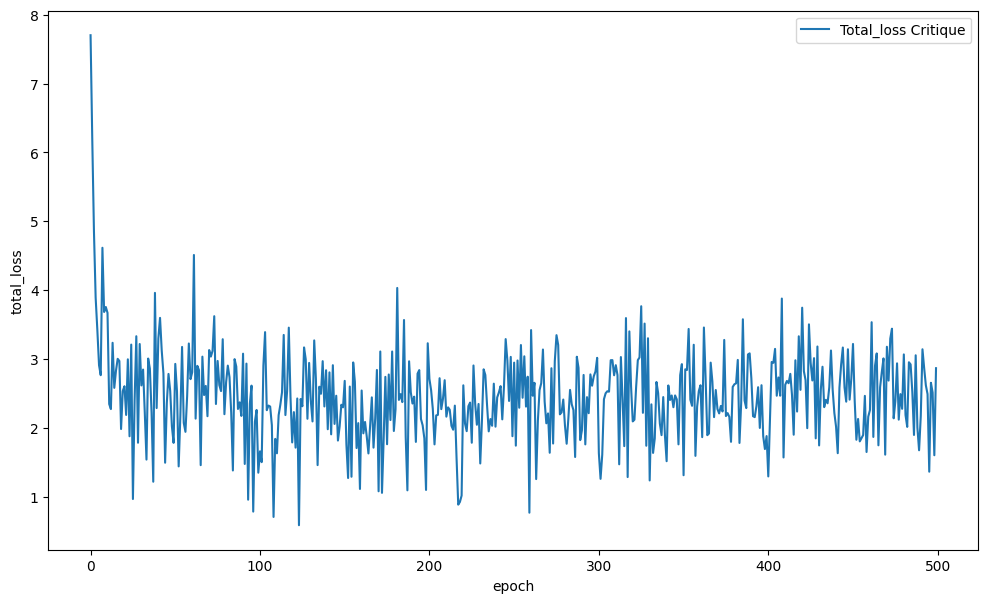

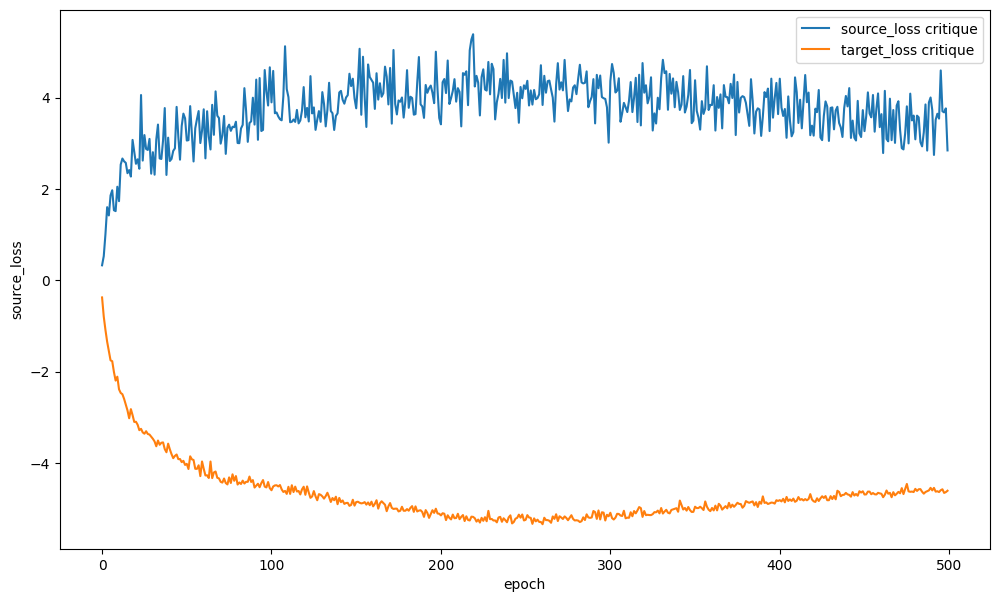

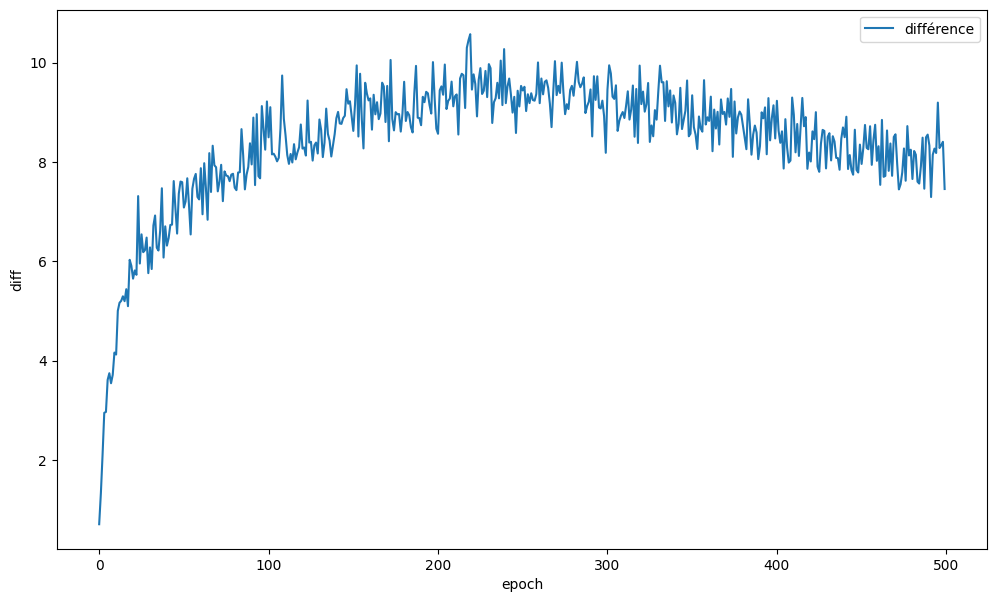

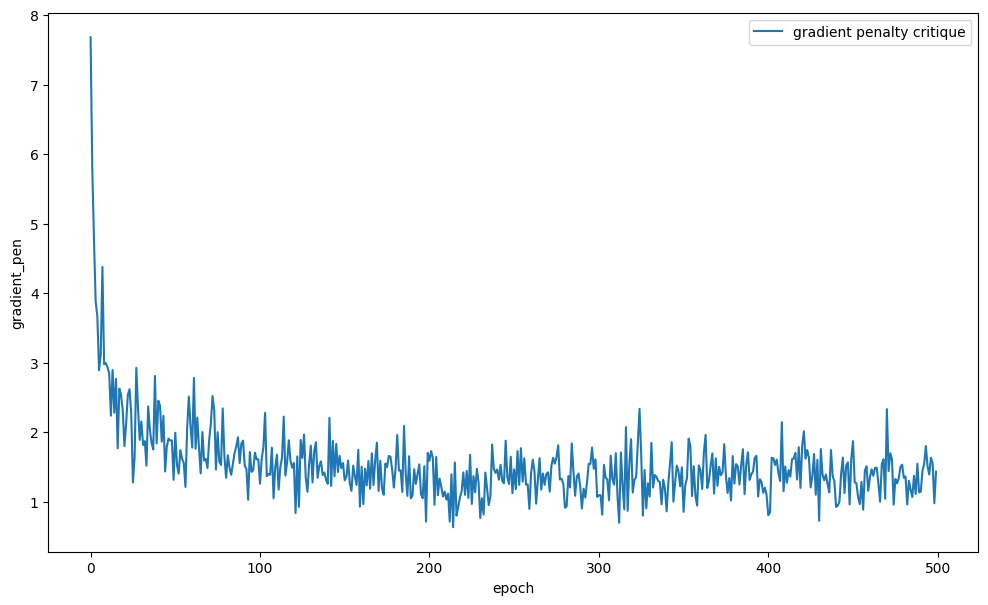

In [7]:
df_le = (
    df_results.sort_values(by=["id", "epoch"], ascending=[False, False])
    .groupby("id", as_index=False)
    .first()
)

plt.figure(figsize=(12, 7))
sns.lineplot(data=df_le, x="epoch", y="total_loss",label="Total_loss Critique")
plt.savefig(path+"Total_loss.png")

#sns.lineplot(data=df_le, x="epoch", y="d_loss_test",label="Discriminator_loss_test")
#sns.lineplot(data=df_le, x="epoch", y="d_loss_val",label="Discriminator_loss_val")

plt.figure(figsize=(12, 7))
sns.lineplot(data=df_le,x="epoch", y="source_loss",label="source_loss critique")
sns.lineplot(data=df_le,x="epoch", y="target_loss",label="target_loss critique")
plt.savefig(path+"Target_loss.png")

plt.figure(figsize=(12, 7))
sns.lineplot(data=df_le,x="epoch", y="diff",label="différence")
plt.savefig(path+"différence_loss.png")

plt.figure(figsize=(12, 7))
sns.lineplot(data=df_le,x="epoch", y="gradient_pen",label="gradient penalty critique")
plt.savefig(path+"grad_penalty.png")

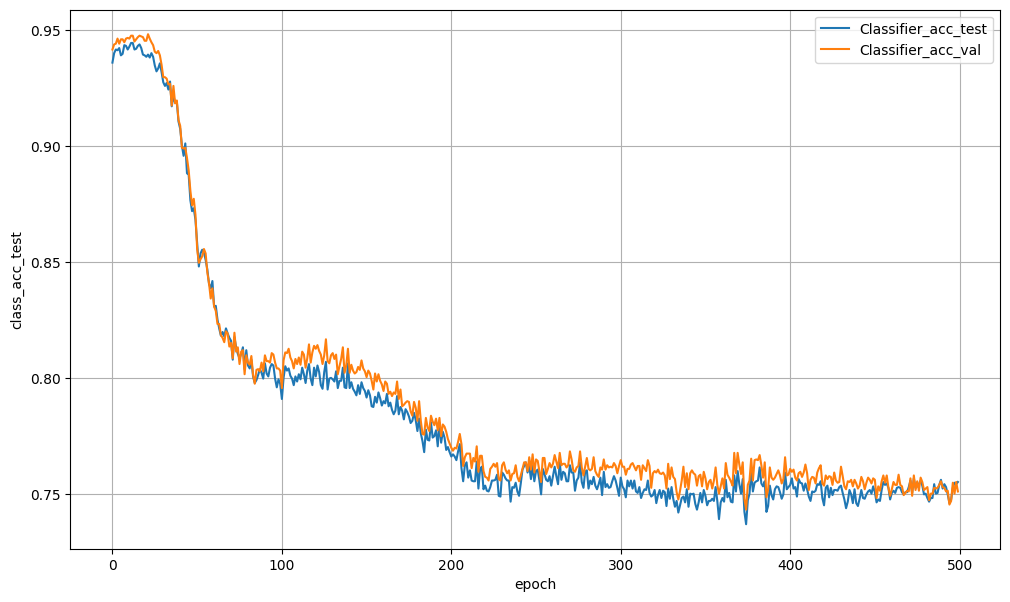

In [8]:
plt.figure(figsize=(12,7))
sns.lineplot(data=df_le, x="epoch", y="class_acc_test", label="Classifier_acc_test")
sns.lineplot(data=df_le, x="epoch", y="class_acc_val", label="Classifier_acc_val")
plt.grid(True)
plt.savefig(path+"classifier_accuracy.png")